In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
#FOLD=int(os.getenv("FOLD"))

In [3]:
FOLD=1

In [4]:
print FOLD

1


In [5]:
sys.path.insert(0,"../python/rrvf2017/")

In [6]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [7]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [8]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz")
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [9]:
gc.collect()

0

# cv

In [10]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [11]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 
                'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 
                'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 
                'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 
                'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 
                'station_count_y3', 'station_count_y4',
               's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio',
               'bad_ratio'])
len(lag_cols)

32

In [12]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [13]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean'
                   ])

In [14]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [15]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [16]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [17]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [18]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,num_leaves=31,subsample=1,
               learning_rate=0.03,max_bin=127,
               min_data_in_leaf=20,lambda_l2=0,
               min_sum_hessian_in_leaf=1e-3, C=0.001,
               objective='binary' ):
        models=[]
        scores=[]
        d_train = lgb.Dataset(trainX, label=trainy,categorical_feature=[0])
        d_valid = lgb.Dataset(validX, label=validy,categorical_feature=[0])
        
        if 1:
            params = {
                'task': 'train',
                'boosting_type': 'gbdt',
                'objective': objective,
                'metric': {'rmse'},
                'num_leaves':num_leaves,
                'learning_rate': learning_rate,
                'feature_fraction': colsample_bytree,
                'bagging_fraction': subsample,
                'min_data_in_leaf': min_data_in_leaf,
                'min_sum_hessian_in_leaf': min_sum_hessian_in_leaf,
                'lambda_l2': lambda_l2,
                'max_bin': max_bin,
                'bagging_freq': 5,
                'nthread': 8,
                'verbose': 0,
                'metric_freq': 50,
                'train_metric': True
            }
            print str(params)
            gbm = lgb.train(params,
                            d_train,
                            num_boost_round=1000,
                            valid_sets=d_valid,
                            early_stopping_rounds=50)

            models.append(gbm)
            validpred=gbm.predict(validX,num_iteration=gbm.best_iteration)
            scores.append(mean_squared_error(validy,validpred))
            print mean_squared_error(trainy,gbm.predict(trainX,num_iteration=gbm.best_iteration)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [19]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [20]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    test_pred=model.predict(testX,num_iteration=model.best_iteration)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        pred=model.predict(X,num_iteration=model.best_iteration).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    pred=model.predict(X,num_iteration=model.best_iteration)
    return pred,dataidx


In [21]:
parameter={'colsample_bytree': 0.5,
 'lambda_l2': 1,
 'learning_rate': 0.05,
 'max_bin': 255,
 'min_data_in_leaf': 30,
 'min_sum_hessian_in_leaf': 0.001,
 'num_leaves': 127,
 'objective': 'regression',
 'subsample': 0.8}

In [22]:
EXCLUDE_HARD=True
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [23]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [24]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds, open('3001eb_lgb_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))



1
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 14.804288
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201819, 2) (48921, 2)
train/valid # (164168, 2) (39785, 2)
rand split across time
train has 164168 records out of 389630 records
valid has 39785 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1282
0
(164168, 1, 18) (164168, 7, 32) (164168, 1) (164168, 1)
(164168, 242) (164168,) (164168,)
(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(5803, 1, 18) (5803, 7, 32) (5803, 1) (5803, 1)
(5803, 242) (5803,) (5803,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'b

/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:1030: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:671: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


[1]	valid_0's rmse: 0.776703
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.757873
[3]	valid_0's rmse: 0.740142
[4]	valid_0's rmse: 0.723906
[5]	valid_0's rmse: 0.708513
[6]	valid_0's rmse: 0.694473
[7]	valid_0's rmse: 0.681738
[8]	valid_0's rmse: 0.669771
[9]	valid_0's rmse: 0.658576
[10]	valid_0's rmse: 0.648142
[11]	valid_0's rmse: 0.638917
[12]	valid_0's rmse: 0.630024
[13]	valid_0's rmse: 0.622244
[14]	valid_0's rmse: 0.614778
[15]	valid_0's rmse: 0.60806
[16]	valid_0's rmse: 0.601662
[17]	valid_0's rmse: 0.596002
[18]	valid_0's rmse: 0.590503
[19]	valid_0's rmse: 0.585686
[20]	valid_0's rmse: 0.581229
[21]	valid_0's rmse: 0.577106
[22]	valid_0's rmse: 0.573329
[23]	valid_0's rmse: 0.569929
[24]	valid_0's rmse: 0.566743
[25]	valid_0's rmse: 0.563872
[26]	valid_0's rmse: 0.561005
[27]	valid_0's rmse: 0.5585
[28]	valid_0's rmse: 0.556192
[29]	valid_0's rmse: 0.553917
[30]	valid_0's rmse: 0.551947
[31]	valid_0's rmse: 0.55018
[32]	valid_0's rmse: 

[272]	valid_0's rmse: 0.519457
[273]	valid_0's rmse: 0.519445
[274]	valid_0's rmse: 0.519434
[275]	valid_0's rmse: 0.519424
[276]	valid_0's rmse: 0.519423
[277]	valid_0's rmse: 0.519411
[278]	valid_0's rmse: 0.519414
[279]	valid_0's rmse: 0.519406
[280]	valid_0's rmse: 0.519397
[281]	valid_0's rmse: 0.519383
[282]	valid_0's rmse: 0.519384
[283]	valid_0's rmse: 0.519372
[284]	valid_0's rmse: 0.519372
[285]	valid_0's rmse: 0.519376
[286]	valid_0's rmse: 0.51938
[287]	valid_0's rmse: 0.519375
[288]	valid_0's rmse: 0.519385
[289]	valid_0's rmse: 0.519386
[290]	valid_0's rmse: 0.519366
[291]	valid_0's rmse: 0.519364
[292]	valid_0's rmse: 0.519353
[293]	valid_0's rmse: 0.519345
[294]	valid_0's rmse: 0.519347
[295]	valid_0's rmse: 0.519339
[296]	valid_0's rmse: 0.519317
[297]	valid_0's rmse: 0.519306
[298]	valid_0's rmse: 0.519302
[299]	valid_0's rmse: 0.519314
[300]	valid_0's rmse: 0.51931
[301]	valid_0's rmse: 0.519301
[302]	valid_0's rmse: 0.519298
[303]	valid_0's rmse: 0.519303
[304]	vali

[541]	valid_0's rmse: 0.518702
[542]	valid_0's rmse: 0.518698
[543]	valid_0's rmse: 0.518692
[544]	valid_0's rmse: 0.518701
[545]	valid_0's rmse: 0.518705
[546]	valid_0's rmse: 0.518704
[547]	valid_0's rmse: 0.518691
[548]	valid_0's rmse: 0.518695
[549]	valid_0's rmse: 0.518691
[550]	valid_0's rmse: 0.518691
[551]	valid_0's rmse: 0.518688
[552]	valid_0's rmse: 0.518689
[553]	valid_0's rmse: 0.518694
[554]	valid_0's rmse: 0.518712
[555]	valid_0's rmse: 0.518715
[556]	valid_0's rmse: 0.518726
[557]	valid_0's rmse: 0.51872
[558]	valid_0's rmse: 0.51873
[559]	valid_0's rmse: 0.518747
[560]	valid_0's rmse: 0.518752
[561]	valid_0's rmse: 0.518747
[562]	valid_0's rmse: 0.51874
[563]	valid_0's rmse: 0.518751
[564]	valid_0's rmse: 0.51874
[565]	valid_0's rmse: 0.518738
[566]	valid_0's rmse: 0.518735
[567]	valid_0's rmse: 0.518724
[568]	valid_0's rmse: 0.518726
[569]	valid_0's rmse: 0.518717
[570]	valid_0's rmse: 0.518717
[571]	valid_0's rmse: 0.518715
[572]	valid_0's rmse: 0.518718
[573]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.920271  0.008839  0.121193    7  2017-04-16
472     2.507290  2.501566  0.005725  0.106548    1  2017-04-17
473     2.661330  2.677235 -0.015905  0.139055    2  2017-04-18
474     2.754815  2.752475  0.002340  0.114545    3  2017-04-19
475     2.713762  2.725794 -0.012033  0.130953    4  2017-04-20
476     2.999000  3.010486 -0.011486  0.089094    5  2017-04-21
477     3.075529  3.085318 -0.009788  0.107560    6  2017-04-22

0.115563943118


pred         y     error    error2  day        date
dayidx                                                         
471     2.920271  2.929110  0.008839  0.121193    7  2017-04-16
472     2.501566  2.507290  0.005725  0.106548    1  2017-04-17
473     2.677235  2.661330 -0.015905  0.139055    2  2017-04-18
474     2.752475  2.754815  0.002340  0.114545    3  2017-04-19
475     2.725794  2.713762 -0.012033  0.130953    4  2017-04-20
476     3.010486  2.999000 -0.011486  0.089094    5  2017-04-21
477     3.085318  3.075529 -0.009788  0.107560    6  2017-04-22

(829, 242)


2
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 14.804288
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201819, 2) (48921, 2)
train/valid # (169559, 2) (41029, 2)
rand split across time
train has 169559 records out of 389630 records
valid has 41029 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1324
0
(169559, 1, 18) (169559, 7, 32) (169559, 1) (169559, 1)
(169559, 242) (169559,) (169559,)
(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(6632, 1, 18) (6632, 7, 32) (6632, 1) (6632, 1)
(6632, 242) (6632,) (6632,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf'

[237]	valid_0's rmse: 0.514159
[238]	valid_0's rmse: 0.514164
[239]	valid_0's rmse: 0.514158
[240]	valid_0's rmse: 0.514164
[241]	valid_0's rmse: 0.514172
[242]	valid_0's rmse: 0.514162
[243]	valid_0's rmse: 0.514165
[244]	valid_0's rmse: 0.514167
[245]	valid_0's rmse: 0.514173
[246]	valid_0's rmse: 0.514157
[247]	valid_0's rmse: 0.514157
[248]	valid_0's rmse: 0.514115
[249]	valid_0's rmse: 0.514102
[250]	valid_0's rmse: 0.514109
[251]	valid_0's rmse: 0.514101
[252]	valid_0's rmse: 0.514098
[253]	valid_0's rmse: 0.514068
[254]	valid_0's rmse: 0.514078
[255]	valid_0's rmse: 0.514071
[256]	valid_0's rmse: 0.514047
[257]	valid_0's rmse: 0.514026
[258]	valid_0's rmse: 0.514016
[259]	valid_0's rmse: 0.514028
[260]	valid_0's rmse: 0.51401
[261]	valid_0's rmse: 0.514001
[262]	valid_0's rmse: 0.513998
[263]	valid_0's rmse: 0.513997
[264]	valid_0's rmse: 0.514004
[265]	valid_0's rmse: 0.514008
[266]	valid_0's rmse: 0.513987
[267]	valid_0's rmse: 0.513976
[268]	valid_0's rmse: 0.513975
[269]	val

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.921481  0.007629  0.148788    7  2017-04-16
472     2.507290  2.519512 -0.012222  0.166209    1  2017-04-17
473     2.661330  2.673018 -0.011688  0.187946    2  2017-04-18
474     2.754815  2.749482  0.005332  0.131619    3  2017-04-19
475     2.713762  2.738100 -0.024338  0.163477    4  2017-04-20
476     2.999000  3.014997 -0.015997  0.109751    5  2017-04-21
477     3.075529  3.079586 -0.004057  0.123355    6  2017-04-22

0.147306399473


pred         y     error    error2  day        date
dayidx                                                         
471     2.921481  2.929110  0.007629  0.148788    7  2017-04-16
472     2.519512  2.507290 -0.012222  0.166209    1  2017-04-17
473     2.673018  2.661330 -0.011688  0.187946    2  2017-04-18
474     2.749482  2.754815  0.005332  0.131619    3  2017-04-19
475     2.738100  2.713762 -0.024338  0.163477    4  2017-04-20
476     3.014997  2.999000 -0.015997  0.109751    5  2017-04-21
477     3.079586  3.075529 -0.004057  0.123355    6  2017-04-22

(829, 242)


3
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 14.804288
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201819, 2) (48921, 2)
train/valid # (170015, 2) (41155, 2)
rand split across time
train has 170015 records out of 389630 records
valid has 41155 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
1328
0
(170015, 1, 18) (170015, 7, 32) (170015, 1) (170015, 1)
(170015, 242) (170015,) (170015,)
(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(7461, 1, 18) (7461, 7, 32) (7461, 1) (7461, 1)
(7461, 242) (7461,) (7461,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf'

[236]	valid_0's rmse: 0.516531
[237]	valid_0's rmse: 0.516521
[238]	valid_0's rmse: 0.516499
[239]	valid_0's rmse: 0.516494
[240]	valid_0's rmse: 0.516495
[241]	valid_0's rmse: 0.516483
[242]	valid_0's rmse: 0.51647
[243]	valid_0's rmse: 0.516464
[244]	valid_0's rmse: 0.516436
[245]	valid_0's rmse: 0.516434
[246]	valid_0's rmse: 0.516424
[247]	valid_0's rmse: 0.516383
[248]	valid_0's rmse: 0.516391
[249]	valid_0's rmse: 0.516395
[250]	valid_0's rmse: 0.516377
[251]	valid_0's rmse: 0.516367
[252]	valid_0's rmse: 0.516358
[253]	valid_0's rmse: 0.516359
[254]	valid_0's rmse: 0.516346
[255]	valid_0's rmse: 0.516345
[256]	valid_0's rmse: 0.51634
[257]	valid_0's rmse: 0.51633
[258]	valid_0's rmse: 0.516314
[259]	valid_0's rmse: 0.516304
[260]	valid_0's rmse: 0.516301
[261]	valid_0's rmse: 0.516276
[262]	valid_0's rmse: 0.516257
[263]	valid_0's rmse: 0.51627
[264]	valid_0's rmse: 0.516265
[265]	valid_0's rmse: 0.516257
[266]	valid_0's rmse: 0.516252
[267]	valid_0's rmse: 0.516279
[268]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.913071  0.016039  0.154770    7  2017-04-16
472     2.507290  2.513795 -0.006505  0.152358    1  2017-04-17
473     2.661330  2.674049 -0.012719  0.199107    2  2017-04-18
474     2.754815  2.769265 -0.014450  0.174313    3  2017-04-19
475     2.713762  2.737127 -0.023365  0.171980    4  2017-04-20
476     2.999000  3.015610 -0.016610  0.112471    5  2017-04-21
477     3.075529  3.080984 -0.005454  0.132985    6  2017-04-22

0.156854761345


pred         y     error    error2  day        date
dayidx                                                         
471     2.913071  2.929110  0.016039  0.154770    7  2017-04-16
472     2.513795  2.507290 -0.006505  0.152358    1  2017-04-17
473     2.674049  2.661330 -0.012719  0.199107    2  2017-04-18
474     2.769265  2.754815 -0.014450  0.174313    3  2017-04-19
475     2.737127  2.713762 -0.023365  0.171980    4  2017-04-20
476     3.015610  2.999000 -0.016610  0.112471    5  2017-04-21
477     3.080984  3.075529 -0.005454  0.132985    6  2017-04-22

(829, 242)


4
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 14.804288
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201819, 2) (48921, 2)
train/valid # (170110, 2) (41185, 2)
rand split across time
train has 170110 records out of 389630 records
valid has 41185 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
1328
0
(170110, 1, 18) (170110, 7, 32) (170110, 1) (170110, 1)
(170110, 242) (170110,) (170110,)
(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(8290, 1, 18) (8290, 7, 32) (8290, 1) (8290, 1)
(8290, 242) (8290,) (8290,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf'

[236]	valid_0's rmse: 0.516962
[237]	valid_0's rmse: 0.516955
[238]	valid_0's rmse: 0.516941
[239]	valid_0's rmse: 0.51692
[240]	valid_0's rmse: 0.516909
[241]	valid_0's rmse: 0.516879
[242]	valid_0's rmse: 0.516858
[243]	valid_0's rmse: 0.51683
[244]	valid_0's rmse: 0.516813
[245]	valid_0's rmse: 0.516794
[246]	valid_0's rmse: 0.516793
[247]	valid_0's rmse: 0.516777
[248]	valid_0's rmse: 0.516755
[249]	valid_0's rmse: 0.516754
[250]	valid_0's rmse: 0.516746
[251]	valid_0's rmse: 0.516747
[252]	valid_0's rmse: 0.516746
[253]	valid_0's rmse: 0.516741
[254]	valid_0's rmse: 0.516746
[255]	valid_0's rmse: 0.51675
[256]	valid_0's rmse: 0.516735
[257]	valid_0's rmse: 0.516734
[258]	valid_0's rmse: 0.516754
[259]	valid_0's rmse: 0.516759
[260]	valid_0's rmse: 0.516754
[261]	valid_0's rmse: 0.516738
[262]	valid_0's rmse: 0.516739
[263]	valid_0's rmse: 0.51673
[264]	valid_0's rmse: 0.516716
[265]	valid_0's rmse: 0.51671
[266]	valid_0's rmse: 0.516698
[267]	valid_0's rmse: 0.516691
[268]	valid_0

[502]	valid_0's rmse: 0.516144
[503]	valid_0's rmse: 0.516138
[504]	valid_0's rmse: 0.516138
[505]	valid_0's rmse: 0.516138
[506]	valid_0's rmse: 0.516143
[507]	valid_0's rmse: 0.516146
[508]	valid_0's rmse: 0.516148
[509]	valid_0's rmse: 0.516144
[510]	valid_0's rmse: 0.51614
[511]	valid_0's rmse: 0.516134
[512]	valid_0's rmse: 0.516123
[513]	valid_0's rmse: 0.516116
[514]	valid_0's rmse: 0.516118
[515]	valid_0's rmse: 0.516113
[516]	valid_0's rmse: 0.516094
[517]	valid_0's rmse: 0.516101
[518]	valid_0's rmse: 0.51611
[519]	valid_0's rmse: 0.516107
[520]	valid_0's rmse: 0.516103
[521]	valid_0's rmse: 0.516106
[522]	valid_0's rmse: 0.516104
[523]	valid_0's rmse: 0.51609
[524]	valid_0's rmse: 0.516085
[525]	valid_0's rmse: 0.516082
[526]	valid_0's rmse: 0.516076
[527]	valid_0's rmse: 0.516062
[528]	valid_0's rmse: 0.516071
[529]	valid_0's rmse: 0.516064
[530]	valid_0's rmse: 0.516077
[531]	valid_0's rmse: 0.516081
[532]	valid_0's rmse: 0.516084
[533]	valid_0's rmse: 0.516098
[534]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.916752  0.012358  0.129954    7  2017-04-16
472     2.507290  2.508541 -0.001251  0.117610    1  2017-04-17
473     2.661330  2.679402 -0.018073  0.158032    2  2017-04-18
474     2.754815  2.741540  0.013275  0.128838    3  2017-04-19
475     2.713762  2.727424 -0.013662  0.164227    4  2017-04-20
476     2.999000  3.003854 -0.004855  0.102619    5  2017-04-21
477     3.075529  3.061494  0.014035  0.109921    6  2017-04-22

0.130171724351


pred         y     error    error2  day        date
dayidx                                                         
471     2.916752  2.929110  0.012358  0.129954    7  2017-04-16
472     2.508541  2.507290 -0.001251  0.117610    1  2017-04-17
473     2.679402  2.661330 -0.018073  0.158032    2  2017-04-18
474     2.741540  2.754815  0.013275  0.128838    3  2017-04-19
475     2.727424  2.713762 -0.013662  0.164227    4  2017-04-20
476     3.003854  2.999000 -0.004855  0.102619    5  2017-04-21
477     3.061494  3.075529  0.014035  0.109921    6  2017-04-22

(829, 242)


5
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 14.804288
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201819, 2) (48921, 2)
train/valid # (170302, 2) (41190, 2)
rand split across time
train has 170302 records out of 389630 records
valid has 41190 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1330
0
(170302, 1, 18) (170302, 7, 32) (170302, 1) (170302, 1)
(170302, 242) (170302,) (170302,)
(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(9119, 1, 18) (9119, 7, 32) (9119, 1) (9119, 1)
(9119, 242) (9119,) (9119,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf'

[237]	valid_0's rmse: 0.518792
[238]	valid_0's rmse: 0.518779
[239]	valid_0's rmse: 0.518776
[240]	valid_0's rmse: 0.518762
[241]	valid_0's rmse: 0.518765
[242]	valid_0's rmse: 0.518749
[243]	valid_0's rmse: 0.518733
[244]	valid_0's rmse: 0.518744
[245]	valid_0's rmse: 0.518714
[246]	valid_0's rmse: 0.518706
[247]	valid_0's rmse: 0.518684
[248]	valid_0's rmse: 0.518674
[249]	valid_0's rmse: 0.518634
[250]	valid_0's rmse: 0.518608
[251]	valid_0's rmse: 0.518598
[252]	valid_0's rmse: 0.518587
[253]	valid_0's rmse: 0.518566
[254]	valid_0's rmse: 0.518566
[255]	valid_0's rmse: 0.518552
[256]	valid_0's rmse: 0.518553
[257]	valid_0's rmse: 0.518545
[258]	valid_0's rmse: 0.518526
[259]	valid_0's rmse: 0.518545
[260]	valid_0's rmse: 0.518538
[261]	valid_0's rmse: 0.518513
[262]	valid_0's rmse: 0.518495
[263]	valid_0's rmse: 0.518486
[264]	valid_0's rmse: 0.518465
[265]	valid_0's rmse: 0.518478
[266]	valid_0's rmse: 0.518469
[267]	valid_0's rmse: 0.51846
[268]	valid_0's rmse: 0.518465
[269]	val

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.915252  0.013857  0.155515    7  2017-04-16
472     2.507290  2.511673 -0.004382  0.147416    1  2017-04-17
473     2.661330  2.670862 -0.009532  0.170114    2  2017-04-18
474     2.754815  2.761832 -0.007018  0.146663    3  2017-04-19
475     2.713762  2.758205 -0.044444  0.184960    4  2017-04-20
476     2.999000  3.015760 -0.016761  0.127257    5  2017-04-21
477     3.075529  3.074417  0.001112  0.127826    6  2017-04-22

0.151393051395


pred         y     error    error2  day        date
dayidx                                                         
471     2.915252  2.929110  0.013857  0.155515    7  2017-04-16
472     2.511673  2.507290 -0.004382  0.147416    1  2017-04-17
473     2.670862  2.661330 -0.009532  0.170114    2  2017-04-18
474     2.761832  2.754815 -0.007018  0.146663    3  2017-04-19
475     2.758205  2.713762 -0.044444  0.184960    4  2017-04-20
476     3.015760  2.999000 -0.016761  0.127257    5  2017-04-21
477     3.074417  3.075529  0.001112  0.127826    6  2017-04-22

(829, 242)


6
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 15.133374
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201819, 2) (48921, 2)
train/valid # (170217, 2) (41200, 2)
rand split across time
train has 170217 records out of 389630 records
valid has 41200 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1329
0
(170217, 1, 18) (170217, 7, 32) (170217, 1) (170217, 1)
(170217, 242) (170217,) (170217,)
(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(9948, 1, 18) (9948, 7, 32) (9948, 1) (9948, 1)
(9948, 242) (9948,) (9948,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf'

[238]	valid_0's rmse: 0.519293
[239]	valid_0's rmse: 0.519292
[240]	valid_0's rmse: 0.519276
[241]	valid_0's rmse: 0.51927
[242]	valid_0's rmse: 0.519252
[243]	valid_0's rmse: 0.519239
[244]	valid_0's rmse: 0.519245
[245]	valid_0's rmse: 0.519215
[246]	valid_0's rmse: 0.519168
[247]	valid_0's rmse: 0.519162
[248]	valid_0's rmse: 0.519167
[249]	valid_0's rmse: 0.519158
[250]	valid_0's rmse: 0.519164
[251]	valid_0's rmse: 0.51916
[252]	valid_0's rmse: 0.519157
[253]	valid_0's rmse: 0.519155
[254]	valid_0's rmse: 0.519139
[255]	valid_0's rmse: 0.519147
[256]	valid_0's rmse: 0.519139
[257]	valid_0's rmse: 0.519138
[258]	valid_0's rmse: 0.519159
[259]	valid_0's rmse: 0.519145
[260]	valid_0's rmse: 0.519146
[261]	valid_0's rmse: 0.519143
[262]	valid_0's rmse: 0.519135
[263]	valid_0's rmse: 0.519128
[264]	valid_0's rmse: 0.519147
[265]	valid_0's rmse: 0.519154
[266]	valid_0's rmse: 0.51915
[267]	valid_0's rmse: 0.519141
[268]	valid_0's rmse: 0.51914
[269]	valid_0's rmse: 0.519133
[270]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.918027  0.011083  0.157222    7  2017-04-16
472     2.507290  2.506130  0.001160  0.147469    1  2017-04-17
473     2.661330  2.669934 -0.008604  0.179672    2  2017-04-18
474     2.754815  2.750868  0.003947  0.136836    3  2017-04-19
475     2.713762  2.736794 -0.023033  0.163336    4  2017-04-20
476     2.999000  2.993090  0.005910  0.121543    5  2017-04-21
477     3.075529  3.091357 -0.015828  0.134589    6  2017-04-22

0.148666556485


pred         y     error    error2  day        date
dayidx                                                         
471     2.918027  2.929110  0.011083  0.157222    7  2017-04-16
472     2.506130  2.507290  0.001160  0.147469    1  2017-04-17
473     2.669934  2.661330 -0.008604  0.179672    2  2017-04-18
474     2.750868  2.754815  0.003947  0.136836    3  2017-04-19
475     2.736794  2.713762 -0.023033  0.163336    4  2017-04-20
476     2.993090  2.999000  0.005910  0.121543    5  2017-04-21
477     3.091357  3.075529 -0.015828  0.134589    6  2017-04-22

(829, 242)


7
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 16.310143
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201819, 2) (48921, 2)
train/valid # (170577, 2) (41308, 2)
rand split across time
train has 170577 records out of 389630 records
valid has 41308 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
1332
0
(170577, 1, 18) (170577, 7, 32) (170577, 1) (170577, 1)
(170577, 242) (170577,) (170577,)
(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(10777, 1, 18) (10777, 7, 32) (10777, 1) (10777, 1)
(10777, 242) (10777,) (10777,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian

[236]	valid_0's rmse: 0.515155
[237]	valid_0's rmse: 0.515145
[238]	valid_0's rmse: 0.515139
[239]	valid_0's rmse: 0.515134
[240]	valid_0's rmse: 0.515137
[241]	valid_0's rmse: 0.515128
[242]	valid_0's rmse: 0.515105
[243]	valid_0's rmse: 0.515091
[244]	valid_0's rmse: 0.515073
[245]	valid_0's rmse: 0.515058
[246]	valid_0's rmse: 0.515023
[247]	valid_0's rmse: 0.515009
[248]	valid_0's rmse: 0.515005
[249]	valid_0's rmse: 0.515
[250]	valid_0's rmse: 0.514988
[251]	valid_0's rmse: 0.51499
[252]	valid_0's rmse: 0.514978
[253]	valid_0's rmse: 0.51498
[254]	valid_0's rmse: 0.514965
[255]	valid_0's rmse: 0.514948
[256]	valid_0's rmse: 0.514943
[257]	valid_0's rmse: 0.514929
[258]	valid_0's rmse: 0.514935
[259]	valid_0's rmse: 0.514921
[260]	valid_0's rmse: 0.51491
[261]	valid_0's rmse: 0.514903
[262]	valid_0's rmse: 0.514885
[263]	valid_0's rmse: 0.514893
[264]	valid_0's rmse: 0.514881
[265]	valid_0's rmse: 0.514873
[266]	valid_0's rmse: 0.514891
[267]	valid_0's rmse: 0.514871
[268]	valid_0'

[503]	valid_0's rmse: 0.514437
[504]	valid_0's rmse: 0.514445
[505]	valid_0's rmse: 0.514445
[506]	valid_0's rmse: 0.514438
[507]	valid_0's rmse: 0.514431
[508]	valid_0's rmse: 0.514434
[509]	valid_0's rmse: 0.514442
[510]	valid_0's rmse: 0.514437
[511]	valid_0's rmse: 0.514446
[512]	valid_0's rmse: 0.514454
[513]	valid_0's rmse: 0.514445
Early stopping, best iteration is:
[463]	valid_0's rmse: 0.514383
0.06076834381228663 0.26458938874048904
[0.26458938874048904]
-1 mean score 0.26458938874048904
0.153537511226


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.928769  0.000341  0.172704    7  2017-04-16
472     2.507290  2.523887 -0.016597  0.147542    1  2017-04-17
473     2.661330  2.675584 -0.014254  0.195986    2  2017-04-18
474     2.754815  2.753801  0.001013  0.145444    3  2017-04-19
475     2.713762  2.730337 -0.016575  0.157722    4  2017-04-20
476     2.999000  3.010389 -0.011389  0.106488    5  2017-04-21
477     3.075529  3.118454 -0.042925  0.148877    6  2017-04-22

0.153537511226


pred         y     error    error2  day        date
dayidx                                                         
471     2.928769  2.929110  0.000341  0.172704    7  2017-04-16
472     2.523887  2.507290 -0.016597  0.147542    1  2017-04-17
473     2.675584  2.661330 -0.014254  0.195986    2  2017-04-18
474     2.753801  2.754815  0.001013  0.145444    3  2017-04-19
475     2.730337  2.713762 -0.016575  0.157722    4  2017-04-20
476     3.010389  2.999000 -0.011389  0.106488    5  2017-04-21
477     3.118454  3.075529 -0.042925  0.148877    6  2017-04-22

(829, 242)


8
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 17.574337
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201819, 2) (48921, 2)
train/valid # (169934, 2) (41199, 2)
rand split across time
train has 169934 records out of 389630 records
valid has 41199 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
1327
0
(169934, 1, 18) (169934, 7, 32) (169934, 1) (169934, 1)
(169934, 242) (169934,) (169934,)
(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(11606, 1, 18) (11606, 7, 32) (11606, 1) (11606, 1)
(11606, 242) (11606,) (11606,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian

[235]	valid_0's rmse: 0.511933
[236]	valid_0's rmse: 0.511943
[237]	valid_0's rmse: 0.511943
[238]	valid_0's rmse: 0.511937
[239]	valid_0's rmse: 0.511937
[240]	valid_0's rmse: 0.511946
[241]	valid_0's rmse: 0.511933
[242]	valid_0's rmse: 0.511945
[243]	valid_0's rmse: 0.511927
[244]	valid_0's rmse: 0.511934
[245]	valid_0's rmse: 0.511931
[246]	valid_0's rmse: 0.511943
[247]	valid_0's rmse: 0.511927
[248]	valid_0's rmse: 0.511937
[249]	valid_0's rmse: 0.511925
[250]	valid_0's rmse: 0.511932
[251]	valid_0's rmse: 0.511931
[252]	valid_0's rmse: 0.511913
[253]	valid_0's rmse: 0.511897
[254]	valid_0's rmse: 0.511876
[255]	valid_0's rmse: 0.511857
[256]	valid_0's rmse: 0.511834
[257]	valid_0's rmse: 0.51183
[258]	valid_0's rmse: 0.511834
[259]	valid_0's rmse: 0.511821
[260]	valid_0's rmse: 0.511819
[261]	valid_0's rmse: 0.511803
[262]	valid_0's rmse: 0.511807
[263]	valid_0's rmse: 0.511802
[264]	valid_0's rmse: 0.511796
[265]	valid_0's rmse: 0.511792
[266]	valid_0's rmse: 0.511789
[267]	val

[502]	valid_0's rmse: 0.511106
[503]	valid_0's rmse: 0.511108
[504]	valid_0's rmse: 0.511102
[505]	valid_0's rmse: 0.511094
[506]	valid_0's rmse: 0.511108
[507]	valid_0's rmse: 0.511121
[508]	valid_0's rmse: 0.511133
[509]	valid_0's rmse: 0.511136
[510]	valid_0's rmse: 0.511129
[511]	valid_0's rmse: 0.51111
[512]	valid_0's rmse: 0.511101
[513]	valid_0's rmse: 0.511114
[514]	valid_0's rmse: 0.511125
[515]	valid_0's rmse: 0.51113
[516]	valid_0's rmse: 0.51113
[517]	valid_0's rmse: 0.511134
[518]	valid_0's rmse: 0.511134
[519]	valid_0's rmse: 0.51115
[520]	valid_0's rmse: 0.511143
[521]	valid_0's rmse: 0.511151
[522]	valid_0's rmse: 0.511156
[523]	valid_0's rmse: 0.511162
[524]	valid_0's rmse: 0.511173
[525]	valid_0's rmse: 0.511162
[526]	valid_0's rmse: 0.511163
[527]	valid_0's rmse: 0.511163
[528]	valid_0's rmse: 0.51115
[529]	valid_0's rmse: 0.511153
[530]	valid_0's rmse: 0.511161
[531]	valid_0's rmse: 0.511158
[532]	valid_0's rmse: 0.51115
[533]	valid_0's rmse: 0.511144
[534]	valid_0'

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.936713 -0.007603  0.176356    7  2017-04-16
472     2.507290  2.519933 -0.012642  0.147633    1  2017-04-17
473     2.661330  2.671190 -0.009861  0.178805    2  2017-04-18
474     2.754815  2.749214  0.005601  0.152090    3  2017-04-19
475     2.713762  2.729847 -0.016085  0.159649    4  2017-04-20
476     2.999000  2.996722  0.002278  0.110768    5  2017-04-21
477     3.075529  3.091630 -0.016101  0.130464    6  2017-04-22

0.150823645005


pred         y     error    error2  day        date
dayidx                                                         
471     2.936713  2.929110 -0.007603  0.176356    7  2017-04-16
472     2.519933  2.507290 -0.012642  0.147633    1  2017-04-17
473     2.671190  2.661330 -0.009861  0.178805    2  2017-04-18
474     2.749214  2.754815  0.005601  0.152090    3  2017-04-19
475     2.729847  2.713762 -0.016085  0.159649    4  2017-04-20
476     2.996722  2.999000  0.002278  0.110768    5  2017-04-21
477     3.091630  3.075529 -0.016101  0.130464    6  2017-04-22

(829, 242)


9
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 18.806503
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201819, 2) (48921, 2)
train/valid # (171018, 2) (41357, 2)
rand split across time
train has 171018 records out of 389630 records
valid has 41357 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1336
0
(171018, 1, 18) (171018, 7, 32) (171018, 1) (171018, 1)
(171018, 242) (171018,) (171018,)
(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(12435, 1, 18) (12435, 7, 32) (12435, 1) (12435, 1)
(12435, 242) (12435,) (12435,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian

[236]	valid_0's rmse: 0.521044
[237]	valid_0's rmse: 0.521046
[238]	valid_0's rmse: 0.521042
[239]	valid_0's rmse: 0.521042
[240]	valid_0's rmse: 0.521036
[241]	valid_0's rmse: 0.521033
[242]	valid_0's rmse: 0.521032
[243]	valid_0's rmse: 0.521028
[244]	valid_0's rmse: 0.52103
[245]	valid_0's rmse: 0.521043
[246]	valid_0's rmse: 0.521029
[247]	valid_0's rmse: 0.521034
[248]	valid_0's rmse: 0.521023
[249]	valid_0's rmse: 0.521012
[250]	valid_0's rmse: 0.521008
[251]	valid_0's rmse: 0.521002
[252]	valid_0's rmse: 0.520997
[253]	valid_0's rmse: 0.521015
[254]	valid_0's rmse: 0.521003
[255]	valid_0's rmse: 0.520998
[256]	valid_0's rmse: 0.520992
[257]	valid_0's rmse: 0.520982
[258]	valid_0's rmse: 0.520981
[259]	valid_0's rmse: 0.520961
[260]	valid_0's rmse: 0.520954
[261]	valid_0's rmse: 0.520948
[262]	valid_0's rmse: 0.520961
[263]	valid_0's rmse: 0.520947
[264]	valid_0's rmse: 0.520957
[265]	valid_0's rmse: 0.520951
[266]	valid_0's rmse: 0.520942
[267]	valid_0's rmse: 0.520935
[268]	val

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.917441  0.011669  0.156604    7  2017-04-16
472     2.507290  2.523784 -0.016494  0.176059    1  2017-04-17
473     2.661330  2.674015 -0.012685  0.194385    2  2017-04-18
474     2.754815  2.747345  0.007470  0.147816    3  2017-04-19
475     2.713762  2.727234 -0.013472  0.168406    4  2017-04-20
476     2.999000  2.999684 -0.000684  0.118947    5  2017-04-21
477     3.075529  3.087101 -0.011572  0.132997    6  2017-04-22

0.156458884428


pred         y     error    error2  day        date
dayidx                                                         
471     2.917441  2.929110  0.011669  0.156604    7  2017-04-16
472     2.523784  2.507290 -0.016494  0.176059    1  2017-04-17
473     2.674015  2.661330 -0.012685  0.194385    2  2017-04-18
474     2.747345  2.754815  0.007470  0.147816    3  2017-04-19
475     2.727234  2.713762 -0.013472  0.168406    4  2017-04-20
476     2.999684  2.999000 -0.000684  0.118947    5  2017-04-21
477     3.087101  3.075529 -0.011572  0.132997    6  2017-04-22

(829, 242)


10
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 19.926521
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201819, 2) (48921, 2)
train/valid # (171123, 2) (41388, 2)
rand split across time
train has 171123 records out of 389630 records
valid has 41388 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1336
0
(171123, 1, 18) (171123, 7, 32) (171123, 1) (171123, 1)
(171123, 242) (171123,) (171123,)
(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(13264, 1, 18) (13264, 7, 32) (13264, 1) (13264, 1)
(13264, 242) (13264,) (13264,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[238]	valid_0's rmse: 0.524095
[239]	valid_0's rmse: 0.524098
[240]	valid_0's rmse: 0.524116
[241]	valid_0's rmse: 0.524109
[242]	valid_0's rmse: 0.524075
[243]	valid_0's rmse: 0.524051
[244]	valid_0's rmse: 0.524034
[245]	valid_0's rmse: 0.524025
[246]	valid_0's rmse: 0.524015
[247]	valid_0's rmse: 0.524002
[248]	valid_0's rmse: 0.524002
[249]	valid_0's rmse: 0.523996
[250]	valid_0's rmse: 0.523997
[251]	valid_0's rmse: 0.523977
[252]	valid_0's rmse: 0.523964
[253]	valid_0's rmse: 0.523945
[254]	valid_0's rmse: 0.523952
[255]	valid_0's rmse: 0.523941
[256]	valid_0's rmse: 0.523916
[257]	valid_0's rmse: 0.523915
[258]	valid_0's rmse: 0.52393
[259]	valid_0's rmse: 0.523913
[260]	valid_0's rmse: 0.523909
[261]	valid_0's rmse: 0.523886
[262]	valid_0's rmse: 0.523872
[263]	valid_0's rmse: 0.523853
[264]	valid_0's rmse: 0.523853
[265]	valid_0's rmse: 0.523845
[266]	valid_0's rmse: 0.523839
[267]	valid_0's rmse: 0.523842
[268]	valid_0's rmse: 0.523832
[269]	valid_0's rmse: 0.523846
[270]	val

0.06370643324977535 0.2737447857146314
[0.2737447857146314]
-1 mean score 0.2737447857146314
0.155506091037


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.923681  0.005429  0.147231    7  2017-04-16
472     2.507290  2.513986 -0.006696  0.145547    1  2017-04-17
473     2.661330  2.673957 -0.012628  0.205425    2  2017-04-18
474     2.754815  2.752167  0.002647  0.165009    3  2017-04-19
475     2.713762  2.737753 -0.023991  0.170259    4  2017-04-20
476     2.999000  3.009100 -0.010100  0.124439    5  2017-04-21
477     3.075529  3.083290 -0.007761  0.130632    6  2017-04-22

0.155506091037


pred         y     error    error2  day        date
dayidx                                                         
471     2.923681  2.929110  0.005429  0.147231    7  2017-04-16
472     2.513986  2.507290 -0.006696  0.145547    1  2017-04-17
473     2.673957  2.661330 -0.012628  0.205425    2  2017-04-18
474     2.752167  2.754815  0.002647  0.165009    3  2017-04-19
475     2.737753  2.713762 -0.023991  0.170259    4  2017-04-20
476     3.009100  2.999000 -0.010100  0.124439    5  2017-04-21
477     3.083290  3.075529 -0.007761  0.130632    6  2017-04-22

(829, 242)


11
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 21.05768
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201819, 2) (48921, 2)
train/valid # (171104, 2) (41361, 2)
rand split across time
train has 171104 records out of 389630 records
valid has 41361 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1336
0
(171104, 1, 18) (171104, 7, 32) (171104, 1) (171104, 1)
(171104, 242) (171104,) (171104,)
(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(14093, 1, 18) (14093, 7, 32) (14093, 1) (14093, 1)
(14093, 242) (14093,) (14093,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian

[235]	valid_0's rmse: 0.525087
[236]	valid_0's rmse: 0.525083
[237]	valid_0's rmse: 0.525074
[238]	valid_0's rmse: 0.525067
[239]	valid_0's rmse: 0.52507
[240]	valid_0's rmse: 0.525058
[241]	valid_0's rmse: 0.525051
[242]	valid_0's rmse: 0.525039
[243]	valid_0's rmse: 0.525027
[244]	valid_0's rmse: 0.525008
[245]	valid_0's rmse: 0.525009
[246]	valid_0's rmse: 0.524965
[247]	valid_0's rmse: 0.524957
[248]	valid_0's rmse: 0.524946
[249]	valid_0's rmse: 0.524942
[250]	valid_0's rmse: 0.524949
[251]	valid_0's rmse: 0.524938
[252]	valid_0's rmse: 0.524931
[253]	valid_0's rmse: 0.524922
[254]	valid_0's rmse: 0.524939
[255]	valid_0's rmse: 0.524923
[256]	valid_0's rmse: 0.524932
[257]	valid_0's rmse: 0.524917
[258]	valid_0's rmse: 0.524918
[259]	valid_0's rmse: 0.5249
[260]	valid_0's rmse: 0.524895
[261]	valid_0's rmse: 0.524883
[262]	valid_0's rmse: 0.524885
[263]	valid_0's rmse: 0.524857
[264]	valid_0's rmse: 0.524824
[265]	valid_0's rmse: 0.524818
[266]	valid_0's rmse: 0.524834
[267]	valid

[501]	valid_0's rmse: 0.524473
[502]	valid_0's rmse: 0.524474
[503]	valid_0's rmse: 0.524468
[504]	valid_0's rmse: 0.524484
[505]	valid_0's rmse: 0.524471
[506]	valid_0's rmse: 0.524468
[507]	valid_0's rmse: 0.52447
[508]	valid_0's rmse: 0.524476
[509]	valid_0's rmse: 0.524485
[510]	valid_0's rmse: 0.524478
[511]	valid_0's rmse: 0.524469
[512]	valid_0's rmse: 0.524466
[513]	valid_0's rmse: 0.524466
[514]	valid_0's rmse: 0.524466
[515]	valid_0's rmse: 0.524452
[516]	valid_0's rmse: 0.524454
[517]	valid_0's rmse: 0.524444
[518]	valid_0's rmse: 0.524432
[519]	valid_0's rmse: 0.524443
[520]	valid_0's rmse: 0.52446
[521]	valid_0's rmse: 0.524464
[522]	valid_0's rmse: 0.524464
[523]	valid_0's rmse: 0.524442
[524]	valid_0's rmse: 0.52444
[525]	valid_0's rmse: 0.524443
[526]	valid_0's rmse: 0.524448
[527]	valid_0's rmse: 0.524452
[528]	valid_0's rmse: 0.52444
[529]	valid_0's rmse: 0.52445
[530]	valid_0's rmse: 0.52444
[531]	valid_0's rmse: 0.524413
[532]	valid_0's rmse: 0.524408
[533]	valid_0'

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912624  0.016486  0.141931    7  2017-04-16
472     2.507290  2.509053 -0.001763  0.127999    1  2017-04-17
473     2.661330  2.671815 -0.010485  0.167870    2  2017-04-18
474     2.754815  2.740110  0.014704  0.153712    3  2017-04-19
475     2.713762  2.744194 -0.030432  0.166355    4  2017-04-20
476     2.999000  3.004760 -0.005760  0.106925    5  2017-04-21
477     3.075529  3.066395  0.009134  0.121637    6  2017-04-22

0.140918419479


pred         y     error    error2  day        date
dayidx                                                         
471     2.912624  2.929110  0.016486  0.141931    7  2017-04-16
472     2.509053  2.507290 -0.001763  0.127999    1  2017-04-17
473     2.671815  2.661330 -0.010485  0.167870    2  2017-04-18
474     2.740110  2.754815  0.014704  0.153712    3  2017-04-19
475     2.744194  2.713762 -0.030432  0.166355    4  2017-04-20
476     3.004760  2.999000 -0.005760  0.106925    5  2017-04-21
477     3.066395  3.075529  0.009134  0.121637    6  2017-04-22

(829, 242)


12
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 22.115147
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201819, 2) (48921, 2)
train/valid # (171118, 2) (41368, 2)
rand split across time
train has 171118 records out of 389630 records
valid has 41368 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1336
0
(171118, 1, 18) (171118, 7, 32) (171118, 1) (171118, 1)
(171118, 242) (171118,) (171118,)
(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(14922, 1, 18) (14922, 7, 32) (14922, 1) (14922, 1)
(14922, 242) (14922,) (14922,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[236]	valid_0's rmse: 0.526631
[237]	valid_0's rmse: 0.526615
[238]	valid_0's rmse: 0.526615
[239]	valid_0's rmse: 0.526611
[240]	valid_0's rmse: 0.526606
[241]	valid_0's rmse: 0.526599
[242]	valid_0's rmse: 0.526597
[243]	valid_0's rmse: 0.526593
[244]	valid_0's rmse: 0.52657
[245]	valid_0's rmse: 0.526567
[246]	valid_0's rmse: 0.526566
[247]	valid_0's rmse: 0.526567
[248]	valid_0's rmse: 0.526571
[249]	valid_0's rmse: 0.52657
[250]	valid_0's rmse: 0.526551
[251]	valid_0's rmse: 0.526539
[252]	valid_0's rmse: 0.526537
[253]	valid_0's rmse: 0.526538
[254]	valid_0's rmse: 0.526533
[255]	valid_0's rmse: 0.526518
[256]	valid_0's rmse: 0.526498
[257]	valid_0's rmse: 0.526456
[258]	valid_0's rmse: 0.526439
[259]	valid_0's rmse: 0.526416
[260]	valid_0's rmse: 0.526403
[261]	valid_0's rmse: 0.526405
[262]	valid_0's rmse: 0.526421
[263]	valid_0's rmse: 0.526412
[264]	valid_0's rmse: 0.526411
[265]	valid_0's rmse: 0.526419
[266]	valid_0's rmse: 0.526406
[267]	valid_0's rmse: 0.52641
[268]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907865  0.021245  0.165065    7  2017-04-16
472     2.507290  2.513594 -0.006303  0.155562    1  2017-04-17
473     2.661330  2.673790 -0.012460  0.182493    2  2017-04-18
474     2.754815  2.746416  0.008399  0.164832    3  2017-04-19
475     2.713762  2.742318 -0.028556  0.189408    4  2017-04-20
476     2.999000  3.001975 -0.002976  0.132951    5  2017-04-21
477     3.075529  3.078886 -0.003357  0.136057    6  2017-04-22

0.160909768177


pred         y     error    error2  day        date
dayidx                                                         
471     2.907865  2.929110  0.021245  0.165065    7  2017-04-16
472     2.513594  2.507290 -0.006303  0.155562    1  2017-04-17
473     2.673790  2.661330 -0.012460  0.182493    2  2017-04-18
474     2.746416  2.754815  0.008399  0.164832    3  2017-04-19
475     2.742318  2.713762 -0.028556  0.189408    4  2017-04-20
476     3.001975  2.999000 -0.002976  0.132951    5  2017-04-21
477     3.078886  3.075529 -0.003357  0.136057    6  2017-04-22

(829, 242)


13
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 23.15517
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201819, 2) (48921, 2)
train/valid # (171021, 2) (41388, 2)
rand split across time
train has 171021 records out of 389630 records
valid has 41388 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1336
0
(171021, 1, 18) (171021, 7, 32) (171021, 1) (171021, 1)
(171021, 242) (171021,) (171021,)
(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(15751, 1, 18) (15751, 7, 32) (15751, 1) (15751, 1)
(15751, 242) (15751,) (15751,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian

[235]	valid_0's rmse: 0.525531
[236]	valid_0's rmse: 0.525512
[237]	valid_0's rmse: 0.525514
[238]	valid_0's rmse: 0.525517
[239]	valid_0's rmse: 0.525518
[240]	valid_0's rmse: 0.525513
[241]	valid_0's rmse: 0.525486
[242]	valid_0's rmse: 0.525469
[243]	valid_0's rmse: 0.525441
[244]	valid_0's rmse: 0.525426
[245]	valid_0's rmse: 0.525414
[246]	valid_0's rmse: 0.525415
[247]	valid_0's rmse: 0.525413
[248]	valid_0's rmse: 0.525405
[249]	valid_0's rmse: 0.525411
[250]	valid_0's rmse: 0.5254
[251]	valid_0's rmse: 0.525391
[252]	valid_0's rmse: 0.525398
[253]	valid_0's rmse: 0.525406
[254]	valid_0's rmse: 0.52539
[255]	valid_0's rmse: 0.525388
[256]	valid_0's rmse: 0.52539
[257]	valid_0's rmse: 0.525382
[258]	valid_0's rmse: 0.525386
[259]	valid_0's rmse: 0.525383
[260]	valid_0's rmse: 0.52537
[261]	valid_0's rmse: 0.525342
[262]	valid_0's rmse: 0.525334
[263]	valid_0's rmse: 0.525359
[264]	valid_0's rmse: 0.525346
[265]	valid_0's rmse: 0.525331
[266]	valid_0's rmse: 0.525318
[267]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907447  0.021663  0.174346    7  2017-04-16
472     2.507290  2.506682  0.000608  0.159485    1  2017-04-17
473     2.661330  2.665352 -0.004022  0.202173    2  2017-04-18
474     2.754815  2.748953  0.005861  0.168946    3  2017-04-19
475     2.713762  2.748234 -0.034472  0.190500    4  2017-04-20
476     2.999000  3.004688 -0.005689  0.139143    5  2017-04-21
477     3.075529  3.075969 -0.000439  0.146269    6  2017-04-22

0.168694531248


pred         y     error    error2  day        date
dayidx                                                         
471     2.907447  2.929110  0.021663  0.174346    7  2017-04-16
472     2.506682  2.507290  0.000608  0.159485    1  2017-04-17
473     2.665352  2.661330 -0.004022  0.202173    2  2017-04-18
474     2.748953  2.754815  0.005861  0.168946    3  2017-04-19
475     2.748234  2.713762 -0.034472  0.190500    4  2017-04-20
476     3.004688  2.999000 -0.005689  0.139143    5  2017-04-21
477     3.075969  3.075529 -0.000439  0.146269    6  2017-04-22

(829, 242)


14
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 24.22639
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201819, 2) (48921, 2)
train/valid # (171207, 2) (41511, 2)
rand split across time
train has 171207 records out of 389630 records
valid has 41511 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1337
0
(171207, 1, 18) (171207, 7, 32) (171207, 1) (171207, 1)
(171207, 242) (171207,) (171207,)
(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(16580, 1, 18) (16580, 7, 32) (16580, 1) (16580, 1)
(16580, 242) (16580,) (16580,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian

[236]	valid_0's rmse: 0.520406
[237]	valid_0's rmse: 0.5204
[238]	valid_0's rmse: 0.52039
[239]	valid_0's rmse: 0.520369
[240]	valid_0's rmse: 0.520361
[241]	valid_0's rmse: 0.520339
[242]	valid_0's rmse: 0.520332
[243]	valid_0's rmse: 0.520334
[244]	valid_0's rmse: 0.520329
[245]	valid_0's rmse: 0.520335
[246]	valid_0's rmse: 0.52033
[247]	valid_0's rmse: 0.520318
[248]	valid_0's rmse: 0.520279
[249]	valid_0's rmse: 0.520275
[250]	valid_0's rmse: 0.52027
[251]	valid_0's rmse: 0.520285
[252]	valid_0's rmse: 0.520279
[253]	valid_0's rmse: 0.520283
[254]	valid_0's rmse: 0.520267
[255]	valid_0's rmse: 0.520268
[256]	valid_0's rmse: 0.520238
[257]	valid_0's rmse: 0.520201
[258]	valid_0's rmse: 0.520181
[259]	valid_0's rmse: 0.52018
[260]	valid_0's rmse: 0.52018
[261]	valid_0's rmse: 0.520188
[262]	valid_0's rmse: 0.520165
[263]	valid_0's rmse: 0.520179
[264]	valid_0's rmse: 0.52018
[265]	valid_0's rmse: 0.52017
[266]	valid_0's rmse: 0.520166
[267]	valid_0's rmse: 0.520154
[268]	valid_0's r

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902213  0.026897  0.197518    7  2017-04-16
472     2.507290  2.521052 -0.013762  0.160112    1  2017-04-17
473     2.661330  2.682118 -0.020789  0.204381    2  2017-04-18
474     2.754815  2.749798  0.005017  0.176128    3  2017-04-19
475     2.713762  2.741366 -0.027605  0.172058    4  2017-04-20
476     2.999000  3.010373 -0.011373  0.124974    5  2017-04-21
477     3.075529  3.111047 -0.035518  0.163568    6  2017-04-22

0.171248472291


pred         y     error    error2  day        date
dayidx                                                         
471     2.902213  2.929110  0.026897  0.197518    7  2017-04-16
472     2.521052  2.507290 -0.013762  0.160112    1  2017-04-17
473     2.682118  2.661330 -0.020789  0.204381    2  2017-04-18
474     2.749798  2.754815  0.005017  0.176128    3  2017-04-19
475     2.741366  2.713762 -0.027605  0.172058    4  2017-04-20
476     3.010373  2.999000 -0.011373  0.124974    5  2017-04-21
477     3.111047  3.075529 -0.035518  0.163568    6  2017-04-22

(829, 242)


15
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 25.357664
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201819, 2) (48921, 2)
train/valid # (170658, 2) (41344, 2)
rand split across time
train has 170658 records out of 389630 records
valid has 41344 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1333
0
(170658, 1, 18) (170658, 7, 32) (170658, 1) (170658, 1)
(170658, 242) (170658,) (170658,)
(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(17409, 1, 18) (17409, 7, 32) (17409, 1) (17409, 1)
(17409, 242) (17409,) (17409,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[236]	valid_0's rmse: 0.520524
[237]	valid_0's rmse: 0.5205
[238]	valid_0's rmse: 0.520522
[239]	valid_0's rmse: 0.520525
[240]	valid_0's rmse: 0.520525
[241]	valid_0's rmse: 0.520527
[242]	valid_0's rmse: 0.520505
[243]	valid_0's rmse: 0.520477
[244]	valid_0's rmse: 0.520466
[245]	valid_0's rmse: 0.520479
[246]	valid_0's rmse: 0.520467
[247]	valid_0's rmse: 0.520467
[248]	valid_0's rmse: 0.52045
[249]	valid_0's rmse: 0.520457
[250]	valid_0's rmse: 0.520456
[251]	valid_0's rmse: 0.520468
[252]	valid_0's rmse: 0.520469
[253]	valid_0's rmse: 0.520455
[254]	valid_0's rmse: 0.520453
[255]	valid_0's rmse: 0.520443
[256]	valid_0's rmse: 0.520443
[257]	valid_0's rmse: 0.520446
[258]	valid_0's rmse: 0.520447
[259]	valid_0's rmse: 0.520448
[260]	valid_0's rmse: 0.520455
[261]	valid_0's rmse: 0.520442
[262]	valid_0's rmse: 0.520417
[263]	valid_0's rmse: 0.520399
[264]	valid_0's rmse: 0.520377
[265]	valid_0's rmse: 0.520374
[266]	valid_0's rmse: 0.520361
[267]	valid_0's rmse: 0.520386
[268]	valid

[506]	valid_0's rmse: 0.51953
[507]	valid_0's rmse: 0.519546
[508]	valid_0's rmse: 0.519546
[509]	valid_0's rmse: 0.519546
[510]	valid_0's rmse: 0.519544
[511]	valid_0's rmse: 0.519535
[512]	valid_0's rmse: 0.519549
[513]	valid_0's rmse: 0.519538
[514]	valid_0's rmse: 0.519528
[515]	valid_0's rmse: 0.519531
[516]	valid_0's rmse: 0.519523
[517]	valid_0's rmse: 0.519514
[518]	valid_0's rmse: 0.519522
[519]	valid_0's rmse: 0.519529
[520]	valid_0's rmse: 0.519528
[521]	valid_0's rmse: 0.519528
[522]	valid_0's rmse: 0.51953
[523]	valid_0's rmse: 0.51952
[524]	valid_0's rmse: 0.519526
[525]	valid_0's rmse: 0.519532
[526]	valid_0's rmse: 0.519539
[527]	valid_0's rmse: 0.519532
[528]	valid_0's rmse: 0.519536
[529]	valid_0's rmse: 0.519539
[530]	valid_0's rmse: 0.519543
[531]	valid_0's rmse: 0.519552
[532]	valid_0's rmse: 0.519556
[533]	valid_0's rmse: 0.519554
[534]	valid_0's rmse: 0.519555
[535]	valid_0's rmse: 0.519554
[536]	valid_0's rmse: 0.519548
[537]	valid_0's rmse: 0.51954
[538]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.932581 -0.003471  0.178234    7  2017-04-16
472     2.507290  2.510398 -0.003108  0.142650    1  2017-04-17
473     2.661330  2.671556 -0.010227  0.188592    2  2017-04-18
474     2.754815  2.755519 -0.000705  0.143029    3  2017-04-19
475     2.713762  2.749755 -0.035993  0.160328    4  2017-04-20
476     2.999000  3.007653 -0.008653  0.104059    5  2017-04-21
477     3.075529  3.092352 -0.016823  0.127820    6  2017-04-22

0.149244667339


pred         y     error    error2  day        date
dayidx                                                         
471     2.932581  2.929110 -0.003471  0.178234    7  2017-04-16
472     2.510398  2.507290 -0.003108  0.142650    1  2017-04-17
473     2.671556  2.661330 -0.010227  0.188592    2  2017-04-18
474     2.755519  2.754815 -0.000705  0.143029    3  2017-04-19
475     2.749755  2.713762 -0.035993  0.160328    4  2017-04-20
476     3.007653  2.999000 -0.008653  0.104059    5  2017-04-21
477     3.092352  3.075529 -0.016823  0.127820    6  2017-04-22

(829, 242)


16
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 26.465925
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201819, 2) (48921, 2)
train/valid # (171566, 2) (41510, 2)
rand split across time
train has 171566 records out of 389630 records
valid has 41510 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1340
0
(171566, 1, 18) (171566, 7, 32) (171566, 1) (171566, 1)
(171566, 242) (171566,) (171566,)
(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(18238, 1, 18) (18238, 7, 32) (18238, 1) (18238, 1)
(18238, 242) (18238,) (18238,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[234]	valid_0's rmse: 0.527394
[235]	valid_0's rmse: 0.527396
[236]	valid_0's rmse: 0.527363
[237]	valid_0's rmse: 0.527365
[238]	valid_0's rmse: 0.527361
[239]	valid_0's rmse: 0.527346
[240]	valid_0's rmse: 0.527338
[241]	valid_0's rmse: 0.527332
[242]	valid_0's rmse: 0.527308
[243]	valid_0's rmse: 0.527327
[244]	valid_0's rmse: 0.52731
[245]	valid_0's rmse: 0.527315
[246]	valid_0's rmse: 0.527315
[247]	valid_0's rmse: 0.527301
[248]	valid_0's rmse: 0.527297
[249]	valid_0's rmse: 0.527291
[250]	valid_0's rmse: 0.527275
[251]	valid_0's rmse: 0.527276
[252]	valid_0's rmse: 0.527283
[253]	valid_0's rmse: 0.527264
[254]	valid_0's rmse: 0.52725
[255]	valid_0's rmse: 0.527249
[256]	valid_0's rmse: 0.527241
[257]	valid_0's rmse: 0.52722
[258]	valid_0's rmse: 0.527185
[259]	valid_0's rmse: 0.527189
[260]	valid_0's rmse: 0.527193
[261]	valid_0's rmse: 0.527172
[262]	valid_0's rmse: 0.527192
[263]	valid_0's rmse: 0.52719
[264]	valid_0's rmse: 0.52719
[265]	valid_0's rmse: 0.527178
[266]	valid_0

[500]	valid_0's rmse: 0.526443
[501]	valid_0's rmse: 0.526438
[502]	valid_0's rmse: 0.526432
[503]	valid_0's rmse: 0.52644
[504]	valid_0's rmse: 0.526451
[505]	valid_0's rmse: 0.526456
[506]	valid_0's rmse: 0.526451
[507]	valid_0's rmse: 0.526453
[508]	valid_0's rmse: 0.526463
[509]	valid_0's rmse: 0.52646
[510]	valid_0's rmse: 0.526467
[511]	valid_0's rmse: 0.526458
[512]	valid_0's rmse: 0.526451
[513]	valid_0's rmse: 0.526434
[514]	valid_0's rmse: 0.526431
[515]	valid_0's rmse: 0.526436
[516]	valid_0's rmse: 0.526431
[517]	valid_0's rmse: 0.526427
[518]	valid_0's rmse: 0.526423
[519]	valid_0's rmse: 0.52641
[520]	valid_0's rmse: 0.526399
[521]	valid_0's rmse: 0.526394
[522]	valid_0's rmse: 0.526394
[523]	valid_0's rmse: 0.526396
[524]	valid_0's rmse: 0.526406
[525]	valid_0's rmse: 0.52641
[526]	valid_0's rmse: 0.52642
[527]	valid_0's rmse: 0.526428
[528]	valid_0's rmse: 0.52643
[529]	valid_0's rmse: 0.526425
[530]	valid_0's rmse: 0.526431
[531]	valid_0's rmse: 0.526442
[532]	valid_0'

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910125  0.018985  0.145967    7  2017-04-16
472     2.507290  2.525470 -0.018179  0.167654    1  2017-04-17
473     2.661330  2.667238 -0.005908  0.201051    2  2017-04-18
474     2.754815  2.747403  0.007412  0.148402    3  2017-04-19
475     2.713762  2.741414 -0.027652  0.169130    4  2017-04-20
476     2.999000  3.016559 -0.017559  0.117236    5  2017-04-21
477     3.075529  3.083525 -0.007996  0.119133    6  2017-04-22

0.152653222657


pred         y     error    error2  day        date
dayidx                                                         
471     2.910125  2.929110  0.018985  0.145967    7  2017-04-16
472     2.525470  2.507290 -0.018179  0.167654    1  2017-04-17
473     2.667238  2.661330 -0.005908  0.201051    2  2017-04-18
474     2.747403  2.754815  0.007412  0.148402    3  2017-04-19
475     2.741414  2.713762 -0.027652  0.169130    4  2017-04-20
476     3.016559  2.999000 -0.017559  0.117236    5  2017-04-21
477     3.083525  3.075529 -0.007996  0.119133    6  2017-04-22

(829, 242)


17
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 27.605818
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201819, 2) (48921, 2)
train/valid # (171844, 2) (41581, 2)
rand split across time
train has 171844 records out of 389630 records
valid has 41581 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1342
0
(171844, 1, 18) (171844, 7, 32) (171844, 1) (171844, 1)
(171844, 242) (171844,) (171844,)
(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(19067, 1, 18) (19067, 7, 32) (19067, 1) (19067, 1)
(19067, 242) (19067,) (19067,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[237]	valid_0's rmse: 0.528544
[238]	valid_0's rmse: 0.528528
[239]	valid_0's rmse: 0.528508
[240]	valid_0's rmse: 0.528502
[241]	valid_0's rmse: 0.528498
[242]	valid_0's rmse: 0.528484
[243]	valid_0's rmse: 0.528479
[244]	valid_0's rmse: 0.528476
[245]	valid_0's rmse: 0.528481
[246]	valid_0's rmse: 0.528485
[247]	valid_0's rmse: 0.528484
[248]	valid_0's rmse: 0.528475
[249]	valid_0's rmse: 0.528473
[250]	valid_0's rmse: 0.528469
[251]	valid_0's rmse: 0.528468
[252]	valid_0's rmse: 0.528435
[253]	valid_0's rmse: 0.52841
[254]	valid_0's rmse: 0.528397
[255]	valid_0's rmse: 0.5284
[256]	valid_0's rmse: 0.528412
[257]	valid_0's rmse: 0.528391
[258]	valid_0's rmse: 0.528393
[259]	valid_0's rmse: 0.528393
[260]	valid_0's rmse: 0.528388
[261]	valid_0's rmse: 0.528395
[262]	valid_0's rmse: 0.528411
[263]	valid_0's rmse: 0.528407
[264]	valid_0's rmse: 0.528411
[265]	valid_0's rmse: 0.528416
[266]	valid_0's rmse: 0.528426
[267]	valid_0's rmse: 0.528425
[268]	valid_0's rmse: 0.528415
[269]	valid

[504]	valid_0's rmse: 0.527803
[505]	valid_0's rmse: 0.527798
[506]	valid_0's rmse: 0.527798
[507]	valid_0's rmse: 0.527798
[508]	valid_0's rmse: 0.527796
[509]	valid_0's rmse: 0.527784
[510]	valid_0's rmse: 0.527799
[511]	valid_0's rmse: 0.527795
[512]	valid_0's rmse: 0.5278
[513]	valid_0's rmse: 0.527793
[514]	valid_0's rmse: 0.527788
[515]	valid_0's rmse: 0.527781
[516]	valid_0's rmse: 0.527779
[517]	valid_0's rmse: 0.527785
[518]	valid_0's rmse: 0.527784
[519]	valid_0's rmse: 0.527776
[520]	valid_0's rmse: 0.527778
[521]	valid_0's rmse: 0.527778
[522]	valid_0's rmse: 0.527771
[523]	valid_0's rmse: 0.52778
[524]	valid_0's rmse: 0.527781
[525]	valid_0's rmse: 0.527786
[526]	valid_0's rmse: 0.527777
[527]	valid_0's rmse: 0.527774
[528]	valid_0's rmse: 0.527775
[529]	valid_0's rmse: 0.527779
[530]	valid_0's rmse: 0.527783
[531]	valid_0's rmse: 0.527778
[532]	valid_0's rmse: 0.527786
[533]	valid_0's rmse: 0.527794
[534]	valid_0's rmse: 0.527795
[535]	valid_0's rmse: 0.527799
[536]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.913551  0.015559  0.137301    7  2017-04-16
472     2.507290  2.497352  0.009938  0.125663    1  2017-04-17
473     2.661330  2.675208 -0.013878  0.195367    2  2017-04-18
474     2.754815  2.752767  0.002047  0.149060    3  2017-04-19
475     2.713762  2.748800 -0.035038  0.166269    4  2017-04-20
476     2.999000  3.018816 -0.019817  0.103387    5  2017-04-21
477     3.075529  3.076550 -0.001020  0.122716    6  2017-04-22

0.142823233408


pred         y     error    error2  day        date
dayidx                                                         
471     2.913551  2.929110  0.015559  0.137301    7  2017-04-16
472     2.497352  2.507290  0.009938  0.125663    1  2017-04-17
473     2.675208  2.661330 -0.013878  0.195367    2  2017-04-18
474     2.752767  2.754815  0.002047  0.149060    3  2017-04-19
475     2.748800  2.713762 -0.035038  0.166269    4  2017-04-20
476     3.018816  2.999000 -0.019817  0.103387    5  2017-04-21
477     3.076550  3.075529 -0.001020  0.122716    6  2017-04-22

(829, 242)


18
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 28.75126
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201819, 2) (48921, 2)
train/valid # (171808, 2) (41563, 2)
rand split across time
train has 171808 records out of 389630 records
valid has 41563 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1342
0
(171808, 1, 18) (171808, 7, 32) (171808, 1) (171808, 1)
(171808, 242) (171808,) (171808,)
(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(19896, 1, 18) (19896, 7, 32) (19896, 1) (19896, 1)
(19896, 242) (19896,) (19896,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian

[237]	valid_0's rmse: 0.528869
[238]	valid_0's rmse: 0.528856
[239]	valid_0's rmse: 0.528848
[240]	valid_0's rmse: 0.52885
[241]	valid_0's rmse: 0.528869
[242]	valid_0's rmse: 0.528866
[243]	valid_0's rmse: 0.528882
[244]	valid_0's rmse: 0.528871
[245]	valid_0's rmse: 0.52886
[246]	valid_0's rmse: 0.528839
[247]	valid_0's rmse: 0.528825
[248]	valid_0's rmse: 0.528816
[249]	valid_0's rmse: 0.528797
[250]	valid_0's rmse: 0.52877
[251]	valid_0's rmse: 0.528768
[252]	valid_0's rmse: 0.528744
[253]	valid_0's rmse: 0.528728
[254]	valid_0's rmse: 0.528738
[255]	valid_0's rmse: 0.528749
[256]	valid_0's rmse: 0.528754
[257]	valid_0's rmse: 0.52873
[258]	valid_0's rmse: 0.528728
[259]	valid_0's rmse: 0.528726
[260]	valid_0's rmse: 0.528711
[261]	valid_0's rmse: 0.528707
[262]	valid_0's rmse: 0.52867
[263]	valid_0's rmse: 0.528668
[264]	valid_0's rmse: 0.528662
[265]	valid_0's rmse: 0.528643
[266]	valid_0's rmse: 0.528644
[267]	valid_0's rmse: 0.528647
[268]	valid_0's rmse: 0.52863
[269]	valid_0'

[507]	valid_0's rmse: 0.528195
[508]	valid_0's rmse: 0.528182
[509]	valid_0's rmse: 0.52818
[510]	valid_0's rmse: 0.528182
[511]	valid_0's rmse: 0.528182
[512]	valid_0's rmse: 0.528191
[513]	valid_0's rmse: 0.528196
[514]	valid_0's rmse: 0.528199
[515]	valid_0's rmse: 0.528204
[516]	valid_0's rmse: 0.528218
[517]	valid_0's rmse: 0.52821
[518]	valid_0's rmse: 0.528212
[519]	valid_0's rmse: 0.528224
[520]	valid_0's rmse: 0.52822
[521]	valid_0's rmse: 0.528215
[522]	valid_0's rmse: 0.528221
[523]	valid_0's rmse: 0.528221
[524]	valid_0's rmse: 0.528226
[525]	valid_0's rmse: 0.528237
[526]	valid_0's rmse: 0.528249
[527]	valid_0's rmse: 0.528243
[528]	valid_0's rmse: 0.528248
[529]	valid_0's rmse: 0.52826
[530]	valid_0's rmse: 0.528254
[531]	valid_0's rmse: 0.52826
[532]	valid_0's rmse: 0.528262
[533]	valid_0's rmse: 0.528253
[534]	valid_0's rmse: 0.528267
[535]	valid_0's rmse: 0.528267
[536]	valid_0's rmse: 0.528267
[537]	valid_0's rmse: 0.52827
[538]	valid_0's rmse: 0.528264
[539]	valid_0'

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897048  0.032062  0.157255    7  2017-04-16
472     2.507290  2.510422 -0.003132  0.133144    1  2017-04-17
473     2.661330  2.670394 -0.009064  0.181992    2  2017-04-18
474     2.754815  2.735698  0.019117  0.170321    3  2017-04-19
475     2.713762  2.719111 -0.005350  0.175842    4  2017-04-20
476     2.999000  3.016167 -0.017167  0.127591    5  2017-04-21
477     3.075529  3.079911 -0.004382  0.133373    6  2017-04-22

0.154216727152


pred         y     error    error2  day        date
dayidx                                                         
471     2.897048  2.929110  0.032062  0.157255    7  2017-04-16
472     2.510422  2.507290 -0.003132  0.133144    1  2017-04-17
473     2.670394  2.661330 -0.009064  0.181992    2  2017-04-18
474     2.735698  2.754815  0.019117  0.170321    3  2017-04-19
475     2.719111  2.713762 -0.005350  0.175842    4  2017-04-20
476     3.016167  2.999000 -0.017167  0.127591    5  2017-04-21
477     3.079911  3.075529 -0.004382  0.133373    6  2017-04-22

(829, 242)


19
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 29.798643
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201819, 2) (48921, 2)
train/valid # (171953, 2) (41543, 2)
rand split across time
train has 171953 records out of 389630 records
valid has 41543 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1343
0
(171953, 1, 18) (171953, 7, 32) (171953, 1) (171953, 1)
(171953, 242) (171953,) (171953,)
(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(20725, 1, 18) (20725, 7, 32) (20725, 1) (20725, 1)
(20725, 242) (20725,) (20725,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[237]	valid_0's rmse: 0.530631
[238]	valid_0's rmse: 0.530612
[239]	valid_0's rmse: 0.530604
[240]	valid_0's rmse: 0.530616
[241]	valid_0's rmse: 0.530621
[242]	valid_0's rmse: 0.530634
[243]	valid_0's rmse: 0.530616
[244]	valid_0's rmse: 0.530598
[245]	valid_0's rmse: 0.530599
[246]	valid_0's rmse: 0.53061
[247]	valid_0's rmse: 0.530597
[248]	valid_0's rmse: 0.530588
[249]	valid_0's rmse: 0.530577
[250]	valid_0's rmse: 0.530576
[251]	valid_0's rmse: 0.530568
[252]	valid_0's rmse: 0.53056
[253]	valid_0's rmse: 0.530541
[254]	valid_0's rmse: 0.530535
[255]	valid_0's rmse: 0.530517
[256]	valid_0's rmse: 0.530513
[257]	valid_0's rmse: 0.530511
[258]	valid_0's rmse: 0.530518
[259]	valid_0's rmse: 0.53051
[260]	valid_0's rmse: 0.530506
[261]	valid_0's rmse: 0.530511
[262]	valid_0's rmse: 0.530518
[263]	valid_0's rmse: 0.530533
[264]	valid_0's rmse: 0.530541
[265]	valid_0's rmse: 0.530544
[266]	valid_0's rmse: 0.53053
[267]	valid_0's rmse: 0.530526
[268]	valid_0's rmse: 0.530518
[269]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910674  0.018436  0.167808    7  2017-04-16
472     2.507290  2.517224 -0.009933  0.152130    1  2017-04-17
473     2.661330  2.669277 -0.007948  0.194007    2  2017-04-18
474     2.754815  2.746654  0.008161  0.162598    3  2017-04-19
475     2.713762  2.744745 -0.030983  0.192410    4  2017-04-20
476     2.999000  3.007695 -0.008695  0.135625    5  2017-04-21
477     3.075529  3.073057  0.002472  0.141214    6  2017-04-22

0.163684723514


pred         y     error    error2  day        date
dayidx                                                         
471     2.910674  2.929110  0.018436  0.167808    7  2017-04-16
472     2.517224  2.507290 -0.009933  0.152130    1  2017-04-17
473     2.669277  2.661330 -0.007948  0.194007    2  2017-04-18
474     2.746654  2.754815  0.008161  0.162598    3  2017-04-19
475     2.744745  2.713762 -0.030983  0.192410    4  2017-04-20
476     3.007695  2.999000 -0.008695  0.135625    5  2017-04-21
477     3.073057  3.075529  0.002472  0.141214    6  2017-04-22

(829, 242)


20
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 30.796307
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201819, 2) (48921, 2)
train/valid # (171699, 2) (41532, 2)
rand split across time
train has 171699 records out of 389630 records
valid has 41532 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1341
0
(171699, 1, 18) (171699, 7, 32) (171699, 1) (171699, 1)
(171699, 242) (171699,) (171699,)
(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(21554, 1, 18) (21554, 7, 32) (21554, 1) (21554, 1)
(21554, 242) (21554,) (21554,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[236]	valid_0's rmse: 0.531633
[237]	valid_0's rmse: 0.531618
[238]	valid_0's rmse: 0.531614
[239]	valid_0's rmse: 0.531601
[240]	valid_0's rmse: 0.5316
[241]	valid_0's rmse: 0.531606
[242]	valid_0's rmse: 0.531573
[243]	valid_0's rmse: 0.53158
[244]	valid_0's rmse: 0.531567
[245]	valid_0's rmse: 0.53158
[246]	valid_0's rmse: 0.531587
[247]	valid_0's rmse: 0.531577
[248]	valid_0's rmse: 0.531576
[249]	valid_0's rmse: 0.531558
[250]	valid_0's rmse: 0.531538
[251]	valid_0's rmse: 0.531537
[252]	valid_0's rmse: 0.531543
[253]	valid_0's rmse: 0.531554
[254]	valid_0's rmse: 0.531555
[255]	valid_0's rmse: 0.531567
[256]	valid_0's rmse: 0.531544
[257]	valid_0's rmse: 0.531563
[258]	valid_0's rmse: 0.531553
[259]	valid_0's rmse: 0.531537
[260]	valid_0's rmse: 0.531541
[261]	valid_0's rmse: 0.531531
[262]	valid_0's rmse: 0.531531
[263]	valid_0's rmse: 0.531543
[264]	valid_0's rmse: 0.531526
[265]	valid_0's rmse: 0.531532
[266]	valid_0's rmse: 0.531516
[267]	valid_0's rmse: 0.531513
[268]	valid_

[504]	valid_0's rmse: 0.530968
[505]	valid_0's rmse: 0.530965
[506]	valid_0's rmse: 0.530971
[507]	valid_0's rmse: 0.530977
[508]	valid_0's rmse: 0.530974
[509]	valid_0's rmse: 0.530991
[510]	valid_0's rmse: 0.530998
[511]	valid_0's rmse: 0.530989
[512]	valid_0's rmse: 0.530982
[513]	valid_0's rmse: 0.530981
[514]	valid_0's rmse: 0.530964
[515]	valid_0's rmse: 0.530961
[516]	valid_0's rmse: 0.530953
[517]	valid_0's rmse: 0.530949
[518]	valid_0's rmse: 0.530941
[519]	valid_0's rmse: 0.530955
[520]	valid_0's rmse: 0.530959
[521]	valid_0's rmse: 0.530967
[522]	valid_0's rmse: 0.530988
[523]	valid_0's rmse: 0.530976
[524]	valid_0's rmse: 0.530976
[525]	valid_0's rmse: 0.530975
[526]	valid_0's rmse: 0.530964
[527]	valid_0's rmse: 0.530975
[528]	valid_0's rmse: 0.530978
[529]	valid_0's rmse: 0.530973
[530]	valid_0's rmse: 0.53097
[531]	valid_0's rmse: 0.530983
[532]	valid_0's rmse: 0.530983
[533]	valid_0's rmse: 0.530982
[534]	valid_0's rmse: 0.530991
[535]	valid_0's rmse: 0.530992
[536]	val

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.930379 -0.001269  0.171284    7  2017-04-16
472     2.507290  2.509226 -0.001936  0.144288    1  2017-04-17
473     2.661330  2.675740 -0.014410  0.175009    2  2017-04-18
474     2.754815  2.743505  0.011309  0.146698    3  2017-04-19
475     2.713762  2.732421 -0.018660  0.163701    4  2017-04-20
476     2.999000  2.991243  0.007757  0.128665    5  2017-04-21
477     3.075529  3.067976  0.007553  0.136537    6  2017-04-22

0.152311804658


pred         y     error    error2  day        date
dayidx                                                         
471     2.930379  2.929110 -0.001269  0.171284    7  2017-04-16
472     2.509226  2.507290 -0.001936  0.144288    1  2017-04-17
473     2.675740  2.661330 -0.014410  0.175009    2  2017-04-18
474     2.743505  2.754815  0.011309  0.146698    3  2017-04-19
475     2.732421  2.713762 -0.018660  0.163701    4  2017-04-20
476     2.991243  2.999000  0.007757  0.128665    5  2017-04-21
477     3.067976  3.075529  0.007553  0.136537    6  2017-04-22

(829, 242)


21
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 31.792852
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201819, 2) (48921, 2)
train/valid # (172014, 2) (41615, 2)
rand split across time
train has 172014 records out of 389630 records
valid has 41615 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1343
0
(172014, 1, 18) (172014, 7, 32) (172014, 1) (172014, 1)
(172014, 242) (172014,) (172014,)
(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(22383, 1, 18) (22383, 7, 32) (22383, 1) (22383, 1)
(22383, 242) (22383,) (22383,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[235]	valid_0's rmse: 0.527878
[236]	valid_0's rmse: 0.527897
[237]	valid_0's rmse: 0.527886
[238]	valid_0's rmse: 0.527858
[239]	valid_0's rmse: 0.527844
[240]	valid_0's rmse: 0.527842
[241]	valid_0's rmse: 0.52785
[242]	valid_0's rmse: 0.527843
[243]	valid_0's rmse: 0.527833
[244]	valid_0's rmse: 0.527823
[245]	valid_0's rmse: 0.52782
[246]	valid_0's rmse: 0.527793
[247]	valid_0's rmse: 0.527783
[248]	valid_0's rmse: 0.52777
[249]	valid_0's rmse: 0.527758
[250]	valid_0's rmse: 0.527742
[251]	valid_0's rmse: 0.527748
[252]	valid_0's rmse: 0.527722
[253]	valid_0's rmse: 0.527734
[254]	valid_0's rmse: 0.527685
[255]	valid_0's rmse: 0.527666
[256]	valid_0's rmse: 0.527659
[257]	valid_0's rmse: 0.527644
[258]	valid_0's rmse: 0.527647
[259]	valid_0's rmse: 0.527638
[260]	valid_0's rmse: 0.527641
[261]	valid_0's rmse: 0.527643
[262]	valid_0's rmse: 0.527637
[263]	valid_0's rmse: 0.527635
[264]	valid_0's rmse: 0.527628
[265]	valid_0's rmse: 0.527619
[266]	valid_0's rmse: 0.527613
[267]	valid

[501]	valid_0's rmse: 0.527021
[502]	valid_0's rmse: 0.527031
[503]	valid_0's rmse: 0.527035
[504]	valid_0's rmse: 0.527039
[505]	valid_0's rmse: 0.527045
[506]	valid_0's rmse: 0.527039
[507]	valid_0's rmse: 0.527047
[508]	valid_0's rmse: 0.52704
[509]	valid_0's rmse: 0.527041
[510]	valid_0's rmse: 0.527044
[511]	valid_0's rmse: 0.52705
[512]	valid_0's rmse: 0.527037
[513]	valid_0's rmse: 0.527037
[514]	valid_0's rmse: 0.527035
[515]	valid_0's rmse: 0.527029
[516]	valid_0's rmse: 0.527023
[517]	valid_0's rmse: 0.527028
[518]	valid_0's rmse: 0.527021
[519]	valid_0's rmse: 0.52702
[520]	valid_0's rmse: 0.527022
[521]	valid_0's rmse: 0.527015
[522]	valid_0's rmse: 0.527011
[523]	valid_0's rmse: 0.527024
[524]	valid_0's rmse: 0.527028
[525]	valid_0's rmse: 0.527019
[526]	valid_0's rmse: 0.527022
[527]	valid_0's rmse: 0.527041
[528]	valid_0's rmse: 0.527046
[529]	valid_0's rmse: 0.527047
[530]	valid_0's rmse: 0.527038
[531]	valid_0's rmse: 0.527037
[532]	valid_0's rmse: 0.527028
[533]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909153  0.019957  0.176817    7  2017-04-16
472     2.507290  2.527230 -0.019940  0.146763    1  2017-04-17
473     2.661330  2.676022 -0.014692  0.188292    2  2017-04-18
474     2.754815  2.749281  0.005534  0.166963    3  2017-04-19
475     2.713762  2.724893 -0.011131  0.170696    4  2017-04-20
476     2.999000  3.001770 -0.002770  0.123168    5  2017-04-21
477     3.075529  3.106607 -0.031078  0.153942    6  2017-04-22

0.160948429303


pred         y     error    error2  day        date
dayidx                                                         
471     2.909153  2.929110  0.019957  0.176817    7  2017-04-16
472     2.527230  2.507290 -0.019940  0.146763    1  2017-04-17
473     2.676022  2.661330 -0.014692  0.188292    2  2017-04-18
474     2.749281  2.754815  0.005534  0.166963    3  2017-04-19
475     2.724893  2.713762 -0.011131  0.170696    4  2017-04-20
476     3.001770  2.999000 -0.002770  0.123168    5  2017-04-21
477     3.106607  3.075529 -0.031078  0.153942    6  2017-04-22

(829, 242)


22
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 32.870983
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201819, 2) (48921, 2)
train/valid # (171457, 2) (41464, 2)
rand split across time
train has 171457 records out of 389630 records
valid has 41464 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1339
0
(171457, 1, 18) (171457, 7, 32) (171457, 1) (171457, 1)
(171457, 242) (171457,) (171457,)
(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(23212, 1, 18) (23212, 7, 32) (23212, 1) (23212, 1)
(23212, 242) (23212,) (23212,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[235]	valid_0's rmse: 0.524961
[236]	valid_0's rmse: 0.524956
[237]	valid_0's rmse: 0.524938
[238]	valid_0's rmse: 0.524935
[239]	valid_0's rmse: 0.524907
[240]	valid_0's rmse: 0.524901
[241]	valid_0's rmse: 0.524889
[242]	valid_0's rmse: 0.524895
[243]	valid_0's rmse: 0.524876
[244]	valid_0's rmse: 0.52487
[245]	valid_0's rmse: 0.524869
[246]	valid_0's rmse: 0.524886
[247]	valid_0's rmse: 0.52489
[248]	valid_0's rmse: 0.524863
[249]	valid_0's rmse: 0.52487
[250]	valid_0's rmse: 0.524866
[251]	valid_0's rmse: 0.524865
[252]	valid_0's rmse: 0.524867
[253]	valid_0's rmse: 0.524874
[254]	valid_0's rmse: 0.524871
[255]	valid_0's rmse: 0.524846
[256]	valid_0's rmse: 0.524852
[257]	valid_0's rmse: 0.524849
[258]	valid_0's rmse: 0.524852
[259]	valid_0's rmse: 0.524846
[260]	valid_0's rmse: 0.524838
[261]	valid_0's rmse: 0.524826
[262]	valid_0's rmse: 0.524819
[263]	valid_0's rmse: 0.524806
[264]	valid_0's rmse: 0.524802
[265]	valid_0's rmse: 0.5248
[266]	valid_0's rmse: 0.524794
[267]	valid_0

[502]	valid_0's rmse: 0.524384
[503]	valid_0's rmse: 0.524381
[504]	valid_0's rmse: 0.524374
[505]	valid_0's rmse: 0.524382
[506]	valid_0's rmse: 0.52438
[507]	valid_0's rmse: 0.524388
[508]	valid_0's rmse: 0.524377
[509]	valid_0's rmse: 0.524378
[510]	valid_0's rmse: 0.524399
[511]	valid_0's rmse: 0.524396
[512]	valid_0's rmse: 0.524389
[513]	valid_0's rmse: 0.524386
[514]	valid_0's rmse: 0.524384
[515]	valid_0's rmse: 0.524381
[516]	valid_0's rmse: 0.524395
[517]	valid_0's rmse: 0.524393
[518]	valid_0's rmse: 0.524392
[519]	valid_0's rmse: 0.524396
[520]	valid_0's rmse: 0.52441
[521]	valid_0's rmse: 0.524418
[522]	valid_0's rmse: 0.52442
[523]	valid_0's rmse: 0.524407
[524]	valid_0's rmse: 0.524406
[525]	valid_0's rmse: 0.524398
[526]	valid_0's rmse: 0.524404
[527]	valid_0's rmse: 0.524409
[528]	valid_0's rmse: 0.524419
[529]	valid_0's rmse: 0.524441
[530]	valid_0's rmse: 0.52442
[531]	valid_0's rmse: 0.52442
[532]	valid_0's rmse: 0.524425
[533]	valid_0's rmse: 0.524427
[534]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.921160  0.007950  0.180408    7  2017-04-16
472     2.507290  2.512996 -0.005705  0.143179    1  2017-04-17
473     2.661330  2.674901 -0.013571  0.181566    2  2017-04-18
474     2.754815  2.751266  0.003549  0.162842    3  2017-04-19
475     2.713762  2.736931 -0.023170  0.176465    4  2017-04-20
476     2.999000  2.992911  0.006088  0.121712    5  2017-04-21
477     3.075529  3.082927 -0.007398  0.136601    6  2017-04-22

0.157539091575


pred         y     error    error2  day        date
dayidx                                                         
471     2.921160  2.929110  0.007950  0.180408    7  2017-04-16
472     2.512996  2.507290 -0.005705  0.143179    1  2017-04-17
473     2.674901  2.661330 -0.013571  0.181566    2  2017-04-18
474     2.751266  2.754815  0.003549  0.162842    3  2017-04-19
475     2.736931  2.713762 -0.023170  0.176465    4  2017-04-20
476     2.992911  2.999000  0.006088  0.121712    5  2017-04-21
477     3.082927  3.075529 -0.007398  0.136601    6  2017-04-22

(829, 242)


23
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 33.974537
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201819, 2) (48921, 2)
train/valid # (172338, 2) (41706, 2)
rand split across time
train has 172338 records out of 389630 records
valid has 41706 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1346
0
(172338, 1, 18) (172338, 7, 32) (172338, 1) (172338, 1)
(172338, 242) (172338,) (172338,)
(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(24041, 1, 18) (24041, 7, 32) (24041, 1) (24041, 1)
(24041, 242) (24041,) (24041,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[238]	valid_0's rmse: 0.529109
[239]	valid_0's rmse: 0.529088
[240]	valid_0's rmse: 0.529096
[241]	valid_0's rmse: 0.529105
[242]	valid_0's rmse: 0.5291
[243]	valid_0's rmse: 0.529089
[244]	valid_0's rmse: 0.529103
[245]	valid_0's rmse: 0.529082
[246]	valid_0's rmse: 0.529052
[247]	valid_0's rmse: 0.529035
[248]	valid_0's rmse: 0.529
[249]	valid_0's rmse: 0.528987
[250]	valid_0's rmse: 0.52899
[251]	valid_0's rmse: 0.528994
[252]	valid_0's rmse: 0.52897
[253]	valid_0's rmse: 0.528977
[254]	valid_0's rmse: 0.528952
[255]	valid_0's rmse: 0.528957
[256]	valid_0's rmse: 0.528954
[257]	valid_0's rmse: 0.528966
[258]	valid_0's rmse: 0.528958
[259]	valid_0's rmse: 0.528955
[260]	valid_0's rmse: 0.528956
[261]	valid_0's rmse: 0.528955
[262]	valid_0's rmse: 0.528955
[263]	valid_0's rmse: 0.528944
[264]	valid_0's rmse: 0.528942
[265]	valid_0's rmse: 0.528931
[266]	valid_0's rmse: 0.52893
[267]	valid_0's rmse: 0.528923
[268]	valid_0's rmse: 0.528917
[269]	valid_0's rmse: 0.528911
[270]	valid_0's 

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.918553  0.010557  0.172511    7  2017-04-16
472     2.507290  2.530148 -0.022858  0.182515    1  2017-04-17
473     2.661330  2.669744 -0.008414  0.211965    2  2017-04-18
474     2.754815  2.754155  0.000660  0.175781    3  2017-04-19
475     2.713762  2.743722 -0.029961  0.190936    4  2017-04-20
476     2.999000  3.001790 -0.002790  0.134267    5  2017-04-21
477     3.075529  3.079682 -0.004152  0.145169    6  2017-04-22

0.17330646675


pred         y     error    error2  day        date
dayidx                                                         
471     2.918553  2.929110  0.010557  0.172511    7  2017-04-16
472     2.530148  2.507290 -0.022858  0.182515    1  2017-04-17
473     2.669744  2.661330 -0.008414  0.211965    2  2017-04-18
474     2.754155  2.754815  0.000660  0.175781    3  2017-04-19
475     2.743722  2.713762 -0.029961  0.190936    4  2017-04-20
476     3.001790  2.999000 -0.002790  0.134267    5  2017-04-21
477     3.079682  3.075529 -0.004152  0.145169    6  2017-04-22

(829, 242)


24
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 35.208443
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201819, 2) (48921, 2)
train/valid # (172616, 2) (41708, 2)
rand split across time
train has 172616 records out of 389630 records
valid has 41708 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1348
0
(172616, 1, 18) (172616, 7, 32) (172616, 1) (172616, 1)
(172616, 242) (172616,) (172616,)
(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(24870, 1, 18) (24870, 7, 32) (24870, 1) (24870, 1)
(24870, 242) (24870,) (24870,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[234]	valid_0's rmse: 0.534008
[235]	valid_0's rmse: 0.533995
[236]	valid_0's rmse: 0.533987
[237]	valid_0's rmse: 0.533991
[238]	valid_0's rmse: 0.533978
[239]	valid_0's rmse: 0.533978
[240]	valid_0's rmse: 0.533957
[241]	valid_0's rmse: 0.533924
[242]	valid_0's rmse: 0.533908
[243]	valid_0's rmse: 0.533907
[244]	valid_0's rmse: 0.533895
[245]	valid_0's rmse: 0.533857
[246]	valid_0's rmse: 0.533858
[247]	valid_0's rmse: 0.53384
[248]	valid_0's rmse: 0.533855
[249]	valid_0's rmse: 0.53387
[250]	valid_0's rmse: 0.533874
[251]	valid_0's rmse: 0.533871
[252]	valid_0's rmse: 0.53387
[253]	valid_0's rmse: 0.533871
[254]	valid_0's rmse: 0.533863
[255]	valid_0's rmse: 0.533863
[256]	valid_0's rmse: 0.533881
[257]	valid_0's rmse: 0.533889
[258]	valid_0's rmse: 0.533882
[259]	valid_0's rmse: 0.5339
[260]	valid_0's rmse: 0.533905
[261]	valid_0's rmse: 0.533917
[262]	valid_0's rmse: 0.533938
[263]	valid_0's rmse: 0.533951
[264]	valid_0's rmse: 0.533975
[265]	valid_0's rmse: 0.533954
[266]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.923578  0.005532  0.165390    7  2017-04-16
472     2.507290  2.502966  0.004324  0.147570    1  2017-04-17
473     2.661330  2.670385 -0.009055  0.206124    2  2017-04-18
474     2.754815  2.753725  0.001089  0.175239    3  2017-04-19
475     2.713762  2.744559 -0.030798  0.188643    4  2017-04-20
476     2.999000  3.014035 -0.015035  0.133507    5  2017-04-21
477     3.075529  3.076480 -0.000951  0.140057    6  2017-04-22

0.165218495902


pred         y     error    error2  day        date
dayidx                                                         
471     2.923578  2.929110  0.005532  0.165390    7  2017-04-16
472     2.502966  2.507290  0.004324  0.147570    1  2017-04-17
473     2.670385  2.661330 -0.009055  0.206124    2  2017-04-18
474     2.753725  2.754815  0.001089  0.175239    3  2017-04-19
475     2.744559  2.713762 -0.030798  0.188643    4  2017-04-20
476     3.014035  2.999000 -0.015035  0.133507    5  2017-04-21
477     3.076480  3.075529 -0.000951  0.140057    6  2017-04-22

(829, 242)


25
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 36.335064
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201819, 2) (48921, 2)
train/valid # (172569, 2) (41670, 2)
rand split across time
train has 172569 records out of 389630 records
valid has 41670 records out of 389630 records
train has 25699 records out of 25699 records
no valid set
1348
0
(172569, 1, 18) (172569, 7, 32) (172569, 1) (172569, 1)
(172569, 242) (172569,) (172569,)
(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(25699, 1, 18) (25699, 7, 32) (25699, 1) (25699, 1)
(25699, 242) (25699,) (25699,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[236]	valid_0's rmse: 0.534024
[237]	valid_0's rmse: 0.53403
[238]	valid_0's rmse: 0.533993
[239]	valid_0's rmse: 0.533987
[240]	valid_0's rmse: 0.533961
[241]	valid_0's rmse: 0.533968
[242]	valid_0's rmse: 0.53397
[243]	valid_0's rmse: 0.533959
[244]	valid_0's rmse: 0.533946
[245]	valid_0's rmse: 0.533957
[246]	valid_0's rmse: 0.53396
[247]	valid_0's rmse: 0.533964
[248]	valid_0's rmse: 0.533948
[249]	valid_0's rmse: 0.533937
[250]	valid_0's rmse: 0.533943
[251]	valid_0's rmse: 0.533947
[252]	valid_0's rmse: 0.533934
[253]	valid_0's rmse: 0.533937
[254]	valid_0's rmse: 0.533919
[255]	valid_0's rmse: 0.533924
[256]	valid_0's rmse: 0.533924
[257]	valid_0's rmse: 0.533918
[258]	valid_0's rmse: 0.533933
[259]	valid_0's rmse: 0.533956
[260]	valid_0's rmse: 0.533962
[261]	valid_0's rmse: 0.533953
[262]	valid_0's rmse: 0.533971
[263]	valid_0's rmse: 0.533945
[264]	valid_0's rmse: 0.533927
[265]	valid_0's rmse: 0.53391
[266]	valid_0's rmse: 0.533907
[267]	valid_0's rmse: 0.533884
[268]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.933912 -0.004802  0.195618    7  2017-04-16
472     2.507290  2.512583 -0.005292  0.166423    1  2017-04-17
473     2.661330  2.669526 -0.008196  0.199132    2  2017-04-18
474     2.754815  2.744115  0.010700  0.188795    3  2017-04-19
475     2.713762  2.721878 -0.008116  0.192359    4  2017-04-20
476     2.999000  3.009801 -0.010801  0.150570    5  2017-04-21
477     3.075529  3.082281 -0.006752  0.154513    6  2017-04-22

0.178201488168


pred         y     error    error2  day        date
dayidx                                                         
471     2.933912  2.929110 -0.004802  0.195618    7  2017-04-16
472     2.512583  2.507290 -0.005292  0.166423    1  2017-04-17
473     2.669526  2.661330 -0.008196  0.199132    2  2017-04-18
474     2.744115  2.754815  0.010700  0.188795    3  2017-04-19
475     2.721878  2.713762 -0.008116  0.192359    4  2017-04-20
476     3.009801  2.999000 -0.010801  0.150570    5  2017-04-21
477     3.082281  3.075529 -0.006752  0.154513    6  2017-04-22

(829, 242)


26
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 37.374123
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201819, 2) (48921, 2)
train/valid # (172625, 2) (41675, 2)
rand split across time
train has 172625 records out of 389630 records
valid has 41675 records out of 389630 records
train has 26528 records out of 26528 records
no valid set
1348
0
(172625, 1, 18) (172625, 7, 32) (172625, 1) (172625, 1)
(172625, 242) (172625,) (172625,)
(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(26528, 1, 18) (26528, 7, 32) (26528, 1) (26528, 1)
(26528, 242) (26528,) (26528,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[236]	valid_0's rmse: 0.535532
[237]	valid_0's rmse: 0.53554
[238]	valid_0's rmse: 0.535512
[239]	valid_0's rmse: 0.535496
[240]	valid_0's rmse: 0.535487
[241]	valid_0's rmse: 0.535481
[242]	valid_0's rmse: 0.53548
[243]	valid_0's rmse: 0.535488
[244]	valid_0's rmse: 0.535503
[245]	valid_0's rmse: 0.535496
[246]	valid_0's rmse: 0.535497
[247]	valid_0's rmse: 0.535493
[248]	valid_0's rmse: 0.535474
[249]	valid_0's rmse: 0.535461
[250]	valid_0's rmse: 0.535461
[251]	valid_0's rmse: 0.535449
[252]	valid_0's rmse: 0.535446
[253]	valid_0's rmse: 0.535429
[254]	valid_0's rmse: 0.535409
[255]	valid_0's rmse: 0.535412
[256]	valid_0's rmse: 0.535395
[257]	valid_0's rmse: 0.535385
[258]	valid_0's rmse: 0.535366
[259]	valid_0's rmse: 0.535359
[260]	valid_0's rmse: 0.535362
[261]	valid_0's rmse: 0.535372
[262]	valid_0's rmse: 0.535398
[263]	valid_0's rmse: 0.535387
[264]	valid_0's rmse: 0.53538
[265]	valid_0's rmse: 0.535366
[266]	valid_0's rmse: 0.535367
[267]	valid_0's rmse: 0.535341
[268]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.922764  0.006346  0.170755    7  2017-04-16
472     2.507290  2.520511 -0.013220  0.166066    1  2017-04-17
473     2.661330  2.668618 -0.007288  0.194830    2  2017-04-18
474     2.754815  2.743019  0.011796  0.170231    3  2017-04-19
475     2.713762  2.723834 -0.010072  0.208284    4  2017-04-20
476     2.999000  3.004257 -0.005257  0.142678    5  2017-04-21
477     3.075529  3.083571 -0.008042  0.145343    6  2017-04-22

0.171169571105


pred         y     error    error2  day        date
dayidx                                                         
471     2.922764  2.929110  0.006346  0.170755    7  2017-04-16
472     2.520511  2.507290 -0.013220  0.166066    1  2017-04-17
473     2.668618  2.661330 -0.007288  0.194830    2  2017-04-18
474     2.743019  2.754815  0.011796  0.170231    3  2017-04-19
475     2.723834  2.713762 -0.010072  0.208284    4  2017-04-20
476     3.004257  2.999000 -0.005257  0.142678    5  2017-04-21
477     3.083571  3.075529 -0.008042  0.145343    6  2017-04-22

(829, 242)


27
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 38.450596
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201819, 2) (48921, 2)
train/valid # (172437, 2) (41699, 2)
rand split across time
train has 172437 records out of 389630 records
valid has 41699 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1347
0
(172437, 1, 18) (172437, 7, 32) (172437, 1) (172437, 1)
(172437, 242) (172437,) (172437,)
(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(27357, 1, 18) (27357, 7, 32) (27357, 1) (27357, 1)
(27357, 242) (27357,) (27357,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[234]	valid_0's rmse: 0.534726
[235]	valid_0's rmse: 0.534721
[236]	valid_0's rmse: 0.534719
[237]	valid_0's rmse: 0.534696
[238]	valid_0's rmse: 0.534687
[239]	valid_0's rmse: 0.534687
[240]	valid_0's rmse: 0.534679
[241]	valid_0's rmse: 0.53469
[242]	valid_0's rmse: 0.534692
[243]	valid_0's rmse: 0.534685
[244]	valid_0's rmse: 0.534686
[245]	valid_0's rmse: 0.534681
[246]	valid_0's rmse: 0.534694
[247]	valid_0's rmse: 0.534671
[248]	valid_0's rmse: 0.534637
[249]	valid_0's rmse: 0.534645
[250]	valid_0's rmse: 0.534662
[251]	valid_0's rmse: 0.534658
[252]	valid_0's rmse: 0.534652
[253]	valid_0's rmse: 0.534669
[254]	valid_0's rmse: 0.534668
[255]	valid_0's rmse: 0.534661
[256]	valid_0's rmse: 0.534673
[257]	valid_0's rmse: 0.534671
[258]	valid_0's rmse: 0.534665
[259]	valid_0's rmse: 0.534691
[260]	valid_0's rmse: 0.534685
[261]	valid_0's rmse: 0.534688
[262]	valid_0's rmse: 0.53468
[263]	valid_0's rmse: 0.534663
[264]	valid_0's rmse: 0.534674
[265]	valid_0's rmse: 0.53466
[266]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.921175  0.007935  0.183015    7  2017-04-16
472     2.507290  2.513918 -0.006628  0.167630    1  2017-04-17
473     2.661330  2.679691 -0.018361  0.196589    2  2017-04-18
474     2.754815  2.750742  0.004072  0.173181    3  2017-04-19
475     2.713762  2.734415 -0.020654  0.184182    4  2017-04-20
476     2.999000  2.990898  0.008101  0.139248    5  2017-04-21
477     3.075529  3.091366 -0.015836  0.150273    6  2017-04-22

0.170588242497


pred         y     error    error2  day        date
dayidx                                                         
471     2.921175  2.929110  0.007935  0.183015    7  2017-04-16
472     2.513918  2.507290 -0.006628  0.167630    1  2017-04-17
473     2.679691  2.661330 -0.018361  0.196589    2  2017-04-18
474     2.750742  2.754815  0.004072  0.173181    3  2017-04-19
475     2.734415  2.713762 -0.020654  0.184182    4  2017-04-20
476     2.990898  2.999000  0.008101  0.139248    5  2017-04-21
477     3.091366  3.075529 -0.015836  0.150273    6  2017-04-22

(829, 242)


28
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 39.47981
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201819, 2) (48921, 2)
train/valid # (172669, 2) (41798, 2)
rand split across time
train has 172669 records out of 389630 records
valid has 41798 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1348
0
(172669, 1, 18) (172669, 7, 32) (172669, 1) (172669, 1)
(172669, 242) (172669,) (172669,)
(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(28186, 1, 18) (28186, 7, 32) (28186, 1) (28186, 1)
(28186, 242) (28186,) (28186,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian

[235]	valid_0's rmse: 0.530663
[236]	valid_0's rmse: 0.530647
[237]	valid_0's rmse: 0.530617
[238]	valid_0's rmse: 0.530608
[239]	valid_0's rmse: 0.530594
[240]	valid_0's rmse: 0.530587
[241]	valid_0's rmse: 0.530571
[242]	valid_0's rmse: 0.530572
[243]	valid_0's rmse: 0.530576
[244]	valid_0's rmse: 0.530571
[245]	valid_0's rmse: 0.530579
[246]	valid_0's rmse: 0.530576
[247]	valid_0's rmse: 0.530559
[248]	valid_0's rmse: 0.530558
[249]	valid_0's rmse: 0.530565
[250]	valid_0's rmse: 0.530556
[251]	valid_0's rmse: 0.53057
[252]	valid_0's rmse: 0.530591
[253]	valid_0's rmse: 0.530573
[254]	valid_0's rmse: 0.530563
[255]	valid_0's rmse: 0.530557
[256]	valid_0's rmse: 0.53053
[257]	valid_0's rmse: 0.530525
[258]	valid_0's rmse: 0.530528
[259]	valid_0's rmse: 0.53053
[260]	valid_0's rmse: 0.530541
[261]	valid_0's rmse: 0.530548
[262]	valid_0's rmse: 0.530536
[263]	valid_0's rmse: 0.530528
[264]	valid_0's rmse: 0.53054
[265]	valid_0's rmse: 0.530538
[266]	valid_0's rmse: 0.530553
[267]	valid_

[505]	valid_0's rmse: 0.530301
[506]	valid_0's rmse: 0.530289
[507]	valid_0's rmse: 0.530279
[508]	valid_0's rmse: 0.530274
[509]	valid_0's rmse: 0.530269
[510]	valid_0's rmse: 0.530267
[511]	valid_0's rmse: 0.530259
[512]	valid_0's rmse: 0.53024
[513]	valid_0's rmse: 0.53025
[514]	valid_0's rmse: 0.530245
[515]	valid_0's rmse: 0.530251
[516]	valid_0's rmse: 0.530258
[517]	valid_0's rmse: 0.530279
[518]	valid_0's rmse: 0.530291
[519]	valid_0's rmse: 0.530297
[520]	valid_0's rmse: 0.530304
[521]	valid_0's rmse: 0.530302
[522]	valid_0's rmse: 0.530306
[523]	valid_0's rmse: 0.530305
[524]	valid_0's rmse: 0.53032
[525]	valid_0's rmse: 0.530306
[526]	valid_0's rmse: 0.530316
[527]	valid_0's rmse: 0.530322
[528]	valid_0's rmse: 0.530314
[529]	valid_0's rmse: 0.530321
[530]	valid_0's rmse: 0.530319
[531]	valid_0's rmse: 0.530312
[532]	valid_0's rmse: 0.530321
[533]	valid_0's rmse: 0.530309
[534]	valid_0's rmse: 0.530321
[535]	valid_0's rmse: 0.530313
[536]	valid_0's rmse: 0.530305
[537]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.928436  0.000674  0.198226    7  2017-04-16
472     2.507290  2.529461 -0.022170  0.162987    1  2017-04-17
473     2.661330  2.679339 -0.018009  0.177835    2  2017-04-18
474     2.754815  2.753728  0.001087  0.153691    3  2017-04-19
475     2.713762  2.723809 -0.010047  0.162778    4  2017-04-20
476     2.999000  2.996484  0.002515  0.116017    5  2017-04-21
477     3.075529  3.101081 -0.025552  0.147027    6  2017-04-22

0.159794473575


pred         y     error    error2  day        date
dayidx                                                         
471     2.928436  2.929110  0.000674  0.198226    7  2017-04-16
472     2.529461  2.507290 -0.022170  0.162987    1  2017-04-17
473     2.679339  2.661330 -0.018009  0.177835    2  2017-04-18
474     2.753728  2.754815  0.001087  0.153691    3  2017-04-19
475     2.723809  2.713762 -0.010047  0.162778    4  2017-04-20
476     2.996484  2.999000  0.002515  0.116017    5  2017-04-21
477     3.101081  3.075529 -0.025552  0.147027    6  2017-04-22

(829, 242)


29
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 40.793427
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201819, 2) (48921, 2)
train/valid # (172132, 2) (41632, 2)
rand split across time
train has 172132 records out of 389630 records
valid has 41632 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
1344
0
(172132, 1, 18) (172132, 7, 32) (172132, 1) (172132, 1)
(172132, 242) (172132,) (172132,)
(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(29015, 1, 18) (29015, 7, 32) (29015, 1) (29015, 1)
(29015, 242) (29015,) (29015,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[236]	valid_0's rmse: 0.528837
[237]	valid_0's rmse: 0.528827
[238]	valid_0's rmse: 0.528814
[239]	valid_0's rmse: 0.528823
[240]	valid_0's rmse: 0.528825
[241]	valid_0's rmse: 0.528809
[242]	valid_0's rmse: 0.528815
[243]	valid_0's rmse: 0.528817
[244]	valid_0's rmse: 0.528774
[245]	valid_0's rmse: 0.528774
[246]	valid_0's rmse: 0.528784
[247]	valid_0's rmse: 0.528773
[248]	valid_0's rmse: 0.528765
[249]	valid_0's rmse: 0.52878
[250]	valid_0's rmse: 0.528797
[251]	valid_0's rmse: 0.528805
[252]	valid_0's rmse: 0.528788
[253]	valid_0's rmse: 0.528773
[254]	valid_0's rmse: 0.52876
[255]	valid_0's rmse: 0.528768
[256]	valid_0's rmse: 0.528735
[257]	valid_0's rmse: 0.52874
[258]	valid_0's rmse: 0.52874
[259]	valid_0's rmse: 0.528732
[260]	valid_0's rmse: 0.528723
[261]	valid_0's rmse: 0.52871
[262]	valid_0's rmse: 0.5287
[263]	valid_0's rmse: 0.528711
[264]	valid_0's rmse: 0.52871
[265]	valid_0's rmse: 0.528712
[266]	valid_0's rmse: 0.528717
[267]	valid_0's rmse: 0.528697
[268]	valid_0's 

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.911957  0.017153  0.204021    7  2017-04-16
472     2.507290  2.540640 -0.033350  0.202755    1  2017-04-17
473     2.661330  2.669735 -0.008405  0.228029    2  2017-04-18
474     2.754815  2.747594  0.007221  0.187408    3  2017-04-19
475     2.713762  2.733993 -0.020231  0.201216    4  2017-04-20
476     2.999000  3.000491 -0.001491  0.146399    5  2017-04-21
477     3.075529  3.092597 -0.017068  0.163483    6  2017-04-22

0.190472879292


pred         y     error    error2  day        date
dayidx                                                         
471     2.911957  2.929110  0.017153  0.204021    7  2017-04-16
472     2.540640  2.507290 -0.033350  0.202755    1  2017-04-17
473     2.669735  2.661330 -0.008405  0.228029    2  2017-04-18
474     2.747594  2.754815  0.007221  0.187408    3  2017-04-19
475     2.733993  2.713762 -0.020231  0.201216    4  2017-04-20
476     3.000491  2.999000 -0.001491  0.146399    5  2017-04-21
477     3.092597  3.075529 -0.017068  0.163483    6  2017-04-22

(829, 242)


30
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 41.98585
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201819, 2) (48921, 2)
train/valid # (173025, 2) (41815, 2)
rand split across time
train has 173025 records out of 389630 records
valid has 41815 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1351
0
(173025, 1, 18) (173025, 7, 32) (173025, 1) (173025, 1)
(173025, 242) (173025,) (173025,)
(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(29844, 1, 18) (29844, 7, 32) (29844, 1) (29844, 1)
(29844, 242) (29844,) (29844,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian

[237]	valid_0's rmse: 0.536356
[238]	valid_0's rmse: 0.536339
[239]	valid_0's rmse: 0.536351
[240]	valid_0's rmse: 0.536334
[241]	valid_0's rmse: 0.536321
[242]	valid_0's rmse: 0.536354
[243]	valid_0's rmse: 0.536349
[244]	valid_0's rmse: 0.536312
[245]	valid_0's rmse: 0.536315
[246]	valid_0's rmse: 0.536292
[247]	valid_0's rmse: 0.536278
[248]	valid_0's rmse: 0.536276
[249]	valid_0's rmse: 0.536259
[250]	valid_0's rmse: 0.536253
[251]	valid_0's rmse: 0.536257
[252]	valid_0's rmse: 0.536238
[253]	valid_0's rmse: 0.536224
[254]	valid_0's rmse: 0.536226
[255]	valid_0's rmse: 0.536227
[256]	valid_0's rmse: 0.536226
[257]	valid_0's rmse: 0.536196
[258]	valid_0's rmse: 0.536213
[259]	valid_0's rmse: 0.536212
[260]	valid_0's rmse: 0.536196
[261]	valid_0's rmse: 0.536202
[262]	valid_0's rmse: 0.536186
[263]	valid_0's rmse: 0.536179
[264]	valid_0's rmse: 0.536172
[265]	valid_0's rmse: 0.536158
[266]	valid_0's rmse: 0.536162
[267]	valid_0's rmse: 0.536161
[268]	valid_0's rmse: 0.536138
[269]	va

[503]	valid_0's rmse: 0.535829
[504]	valid_0's rmse: 0.535851
[505]	valid_0's rmse: 0.535861
[506]	valid_0's rmse: 0.535867
[507]	valid_0's rmse: 0.535872
[508]	valid_0's rmse: 0.535883
[509]	valid_0's rmse: 0.535877
[510]	valid_0's rmse: 0.53588
[511]	valid_0's rmse: 0.535866
[512]	valid_0's rmse: 0.535881
[513]	valid_0's rmse: 0.535888
[514]	valid_0's rmse: 0.535876
[515]	valid_0's rmse: 0.535882
[516]	valid_0's rmse: 0.535884
[517]	valid_0's rmse: 0.535876
[518]	valid_0's rmse: 0.535869
[519]	valid_0's rmse: 0.535874
[520]	valid_0's rmse: 0.535874
[521]	valid_0's rmse: 0.535887
[522]	valid_0's rmse: 0.535882
[523]	valid_0's rmse: 0.535891
[524]	valid_0's rmse: 0.535884
[525]	valid_0's rmse: 0.535888
[526]	valid_0's rmse: 0.535882
[527]	valid_0's rmse: 0.535892
[528]	valid_0's rmse: 0.535891
[529]	valid_0's rmse: 0.535878
[530]	valid_0's rmse: 0.535884
[531]	valid_0's rmse: 0.535885
[532]	valid_0's rmse: 0.535884
[533]	valid_0's rmse: 0.535898
[534]	valid_0's rmse: 0.535896
[535]	val

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.913970  0.015140  0.153553    7  2017-04-16
472     2.507290  2.542762 -0.035471  0.175140    1  2017-04-17
473     2.661330  2.654162  0.007168  0.208936    2  2017-04-18
474     2.754815  2.761369 -0.006554  0.167368    3  2017-04-19
475     2.713762  2.738942 -0.025180  0.175142    4  2017-04-20
476     2.999000  3.006352 -0.007352  0.130720    5  2017-04-21
477     3.075529  3.086846 -0.011317  0.134863    6  2017-04-22

0.163674544475


pred         y     error    error2  day        date
dayidx                                                         
471     2.913970  2.929110  0.015140  0.153553    7  2017-04-16
472     2.542762  2.507290 -0.035471  0.175140    1  2017-04-17
473     2.654162  2.661330  0.007168  0.208936    2  2017-04-18
474     2.761369  2.754815 -0.006554  0.167368    3  2017-04-19
475     2.738942  2.713762 -0.025180  0.175142    4  2017-04-20
476     3.006352  2.999000 -0.007352  0.130720    5  2017-04-21
477     3.086846  3.075529 -0.011317  0.134863    6  2017-04-22

(829, 242)


31
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 43.22814
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201819, 2) (48921, 2)
train/valid # (173280, 2) (41846, 2)
rand split across time
train has 173280 records out of 389630 records
valid has 41846 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1353
0
(173280, 1, 18) (173280, 7, 32) (173280, 1) (173280, 1)
(173280, 242) (173280,) (173280,)
(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(30673, 1, 18) (30673, 7, 32) (30673, 1) (30673, 1)
(30673, 242) (30673,) (30673,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian

[235]	valid_0's rmse: 0.538771
[236]	valid_0's rmse: 0.538771
[237]	valid_0's rmse: 0.538753
[238]	valid_0's rmse: 0.538745
[239]	valid_0's rmse: 0.538749
[240]	valid_0's rmse: 0.538754
[241]	valid_0's rmse: 0.538765
[242]	valid_0's rmse: 0.538753
[243]	valid_0's rmse: 0.538746
[244]	valid_0's rmse: 0.53873
[245]	valid_0's rmse: 0.538743
[246]	valid_0's rmse: 0.538754
[247]	valid_0's rmse: 0.538753
[248]	valid_0's rmse: 0.538768
[249]	valid_0's rmse: 0.538774
[250]	valid_0's rmse: 0.538793
[251]	valid_0's rmse: 0.538808
[252]	valid_0's rmse: 0.538815
[253]	valid_0's rmse: 0.538803
[254]	valid_0's rmse: 0.538805
[255]	valid_0's rmse: 0.538792
[256]	valid_0's rmse: 0.538784
[257]	valid_0's rmse: 0.538756
[258]	valid_0's rmse: 0.538752
[259]	valid_0's rmse: 0.538734
[260]	valid_0's rmse: 0.53872
[261]	valid_0's rmse: 0.538724
[262]	valid_0's rmse: 0.538721
[263]	valid_0's rmse: 0.538736
[264]	valid_0's rmse: 0.538714
[265]	valid_0's rmse: 0.538731
[266]	valid_0's rmse: 0.538726
[267]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909516  0.019594  0.163329    7  2017-04-16
472     2.507290  2.529241 -0.021950  0.156477    1  2017-04-17
473     2.661330  2.655207  0.006123  0.212746    2  2017-04-18
474     2.754815  2.752174  0.002641  0.186960    3  2017-04-19
475     2.713762  2.729467 -0.015706  0.184139    4  2017-04-20
476     2.999000  3.009667 -0.010667  0.132591    5  2017-04-21
477     3.075529  3.089741 -0.014211  0.145386    6  2017-04-22

0.168803984908


pred         y     error    error2  day        date
dayidx                                                         
471     2.909516  2.929110  0.019594  0.163329    7  2017-04-16
472     2.529241  2.507290 -0.021950  0.156477    1  2017-04-17
473     2.655207  2.661330  0.006123  0.212746    2  2017-04-18
474     2.752174  2.754815  0.002641  0.186960    3  2017-04-19
475     2.729467  2.713762 -0.015706  0.184139    4  2017-04-20
476     3.009667  2.999000 -0.010667  0.132591    5  2017-04-21
477     3.089741  3.075529 -0.014211  0.145386    6  2017-04-22

(829, 242)


32
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 44.446426
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201819, 2) (48921, 2)
train/valid # (173200, 2) (41875, 2)
rand split across time
train has 173200 records out of 389630 records
valid has 41875 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1353
0
(173200, 1, 18) (173200, 7, 32) (173200, 1) (173200, 1)
(173200, 242) (173200,) (173200,)
(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(31502, 1, 18) (31502, 7, 32) (31502, 1) (31502, 1)
(31502, 242) (31502,) (31502,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[236]	valid_0's rmse: 0.537965
[237]	valid_0's rmse: 0.537952
[238]	valid_0's rmse: 0.537945
[239]	valid_0's rmse: 0.537944
[240]	valid_0's rmse: 0.537918
[241]	valid_0's rmse: 0.5379
[242]	valid_0's rmse: 0.537886
[243]	valid_0's rmse: 0.53788
[244]	valid_0's rmse: 0.537885
[245]	valid_0's rmse: 0.537868
[246]	valid_0's rmse: 0.53785
[247]	valid_0's rmse: 0.537868
[248]	valid_0's rmse: 0.53785
[249]	valid_0's rmse: 0.53786
[250]	valid_0's rmse: 0.537866
[251]	valid_0's rmse: 0.537861
[252]	valid_0's rmse: 0.537853
[253]	valid_0's rmse: 0.537863
[254]	valid_0's rmse: 0.537854
[255]	valid_0's rmse: 0.537849
[256]	valid_0's rmse: 0.537801
[257]	valid_0's rmse: 0.537772
[258]	valid_0's rmse: 0.537781
[259]	valid_0's rmse: 0.537773
[260]	valid_0's rmse: 0.537738
[261]	valid_0's rmse: 0.537735
[262]	valid_0's rmse: 0.537738
[263]	valid_0's rmse: 0.537738
[264]	valid_0's rmse: 0.537739
[265]	valid_0's rmse: 0.53775
[266]	valid_0's rmse: 0.53776
[267]	valid_0's rmse: 0.537752
[268]	valid_0's 

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900348  0.028762  0.198520    7  2017-04-16
472     2.507290  2.529256 -0.021965  0.175727    1  2017-04-17
473     2.661330  2.661276  0.000054  0.208534    2  2017-04-18
474     2.754815  2.740776  0.014039  0.193013    3  2017-04-19
475     2.713762  2.728444 -0.014683  0.220443    4  2017-04-20
476     2.999000  2.990386  0.008614  0.147623    5  2017-04-21
477     3.075529  3.090212 -0.014683  0.157933    6  2017-04-22

0.185970409419


pred         y     error    error2  day        date
dayidx                                                         
471     2.900348  2.929110  0.028762  0.198520    7  2017-04-16
472     2.529256  2.507290 -0.021965  0.175727    1  2017-04-17
473     2.661276  2.661330  0.000054  0.208534    2  2017-04-18
474     2.740776  2.754815  0.014039  0.193013    3  2017-04-19
475     2.728444  2.713762 -0.014683  0.220443    4  2017-04-20
476     2.990386  2.999000  0.008614  0.147623    5  2017-04-21
477     3.090212  3.075529 -0.014683  0.157933    6  2017-04-22

(829, 242)


33
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 45.511513
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201819, 2) (48921, 2)
train/valid # (173240, 2) (41891, 2)
rand split across time
train has 173240 records out of 389630 records
valid has 41891 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1353
0
(173240, 1, 18) (173240, 7, 32) (173240, 1) (173240, 1)
(173240, 242) (173240,) (173240,)
(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(32331, 1, 18) (32331, 7, 32) (32331, 1) (32331, 1)
(32331, 242) (32331,) (32331,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[236]	valid_0's rmse: 0.539593
[237]	valid_0's rmse: 0.539552
[238]	valid_0's rmse: 0.539554
[239]	valid_0's rmse: 0.53954
[240]	valid_0's rmse: 0.539524
[241]	valid_0's rmse: 0.539542
[242]	valid_0's rmse: 0.53952
[243]	valid_0's rmse: 0.539517
[244]	valid_0's rmse: 0.539512
[245]	valid_0's rmse: 0.539507
[246]	valid_0's rmse: 0.539534
[247]	valid_0's rmse: 0.539541
[248]	valid_0's rmse: 0.53955
[249]	valid_0's rmse: 0.539553
[250]	valid_0's rmse: 0.539567
[251]	valid_0's rmse: 0.539557
[252]	valid_0's rmse: 0.539535
[253]	valid_0's rmse: 0.539527
[254]	valid_0's rmse: 0.539522
[255]	valid_0's rmse: 0.539497
[256]	valid_0's rmse: 0.539486
[257]	valid_0's rmse: 0.539472
[258]	valid_0's rmse: 0.539471
[259]	valid_0's rmse: 0.539468
[260]	valid_0's rmse: 0.539449
[261]	valid_0's rmse: 0.539458
[262]	valid_0's rmse: 0.539446
[263]	valid_0's rmse: 0.539442
[264]	valid_0's rmse: 0.539461
[265]	valid_0's rmse: 0.539458
[266]	valid_0's rmse: 0.539462
[267]	valid_0's rmse: 0.539449
[268]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898674  0.030436  0.177130    7  2017-04-16
472     2.507290  2.517566 -0.010276  0.168505    1  2017-04-17
473     2.661330  2.668740 -0.007410  0.190463    2  2017-04-18
474     2.754815  2.747567  0.007247  0.174317    3  2017-04-19
475     2.713762  2.728439 -0.014677  0.207370    4  2017-04-20
476     2.999000  2.985709  0.013291  0.152559    5  2017-04-21
477     3.075529  3.076433 -0.000904  0.153099    6  2017-04-22

0.174777507842


pred         y     error    error2  day        date
dayidx                                                         
471     2.898674  2.929110  0.030436  0.177130    7  2017-04-16
472     2.517566  2.507290 -0.010276  0.168505    1  2017-04-17
473     2.668740  2.661330 -0.007410  0.190463    2  2017-04-18
474     2.747567  2.754815  0.007247  0.174317    3  2017-04-19
475     2.728439  2.713762 -0.014677  0.207370    4  2017-04-20
476     2.985709  2.999000  0.013291  0.152559    5  2017-04-21
477     3.076433  3.075529 -0.000904  0.153099    6  2017-04-22

(829, 242)


34
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 46.568817
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201819, 2) (48921, 2)
train/valid # (173143, 2) (41860, 2)
rand split across time
train has 173143 records out of 389630 records
valid has 41860 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
1352
0
(173143, 1, 18) (173143, 7, 32) (173143, 1) (173143, 1)
(173143, 242) (173143,) (173143,)
(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(33160, 1, 18) (33160, 7, 32) (33160, 1) (33160, 1)
(33160, 242) (33160,) (33160,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[238]	valid_0's rmse: 0.539018
[239]	valid_0's rmse: 0.539012
[240]	valid_0's rmse: 0.539002
[241]	valid_0's rmse: 0.539
[242]	valid_0's rmse: 0.53901
[243]	valid_0's rmse: 0.539013
[244]	valid_0's rmse: 0.539002
[245]	valid_0's rmse: 0.53901
[246]	valid_0's rmse: 0.539026
[247]	valid_0's rmse: 0.539016
[248]	valid_0's rmse: 0.539008
[249]	valid_0's rmse: 0.539008
[250]	valid_0's rmse: 0.539015
[251]	valid_0's rmse: 0.539025
[252]	valid_0's rmse: 0.539037
[253]	valid_0's rmse: 0.539059
[254]	valid_0's rmse: 0.539078
[255]	valid_0's rmse: 0.539091
[256]	valid_0's rmse: 0.539066
[257]	valid_0's rmse: 0.539069
[258]	valid_0's rmse: 0.539077
[259]	valid_0's rmse: 0.539058
[260]	valid_0's rmse: 0.539066
[261]	valid_0's rmse: 0.539063
[262]	valid_0's rmse: 0.539065
[263]	valid_0's rmse: 0.539046
[264]	valid_0's rmse: 0.539041
[265]	valid_0's rmse: 0.539042
[266]	valid_0's rmse: 0.539042
[267]	valid_0's rmse: 0.539023
[268]	valid_0's rmse: 0.539027
[269]	valid_0's rmse: 0.539024
[270]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.916391  0.012719  0.203062    7  2017-04-16
472     2.507290  2.539783 -0.032493  0.188673    1  2017-04-17
473     2.661330  2.667062 -0.005732  0.226954    2  2017-04-18
474     2.754815  2.758023 -0.003209  0.193160    3  2017-04-19
475     2.713762  2.731607 -0.017845  0.210706    4  2017-04-20
476     2.999000  2.991462  0.007538  0.156716    5  2017-04-21
477     3.075529  3.107918 -0.032389  0.180454    6  2017-04-22

0.194246388739


pred         y     error    error2  day        date
dayidx                                                         
471     2.916391  2.929110  0.012719  0.203062    7  2017-04-16
472     2.539783  2.507290 -0.032493  0.188673    1  2017-04-17
473     2.667062  2.661330 -0.005732  0.226954    2  2017-04-18
474     2.758023  2.754815 -0.003209  0.193160    3  2017-04-19
475     2.731607  2.713762 -0.017845  0.210706    4  2017-04-20
476     2.991462  2.999000  0.007538  0.156716    5  2017-04-21
477     3.107918  3.075529 -0.032389  0.180454    6  2017-04-22

(829, 242)


35
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 47.473278
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201819, 2) (48921, 2)
train/valid # (173455, 2) (41989, 2)
rand split across time
train has 173455 records out of 389630 records
valid has 41989 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1355
0
(173455, 1, 18) (173455, 7, 32) (173455, 1) (173455, 1)
(173455, 242) (173455,) (173455,)
(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(33989, 1, 18) (33989, 7, 32) (33989, 1) (33989, 1)
(33989, 242) (33989,) (33989,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[236]	valid_0's rmse: 0.533644
[237]	valid_0's rmse: 0.533618
[238]	valid_0's rmse: 0.533616
[239]	valid_0's rmse: 0.533616
[240]	valid_0's rmse: 0.533611
[241]	valid_0's rmse: 0.533613
[242]	valid_0's rmse: 0.533609
[243]	valid_0's rmse: 0.533622
[244]	valid_0's rmse: 0.533618
[245]	valid_0's rmse: 0.533605
[246]	valid_0's rmse: 0.533577
[247]	valid_0's rmse: 0.533587
[248]	valid_0's rmse: 0.533576
[249]	valid_0's rmse: 0.533568
[250]	valid_0's rmse: 0.533556
[251]	valid_0's rmse: 0.533559
[252]	valid_0's rmse: 0.533546
[253]	valid_0's rmse: 0.533542
[254]	valid_0's rmse: 0.533526
[255]	valid_0's rmse: 0.533518
[256]	valid_0's rmse: 0.533519
[257]	valid_0's rmse: 0.5335
[258]	valid_0's rmse: 0.533522
[259]	valid_0's rmse: 0.533528
[260]	valid_0's rmse: 0.533535
[261]	valid_0's rmse: 0.533498
[262]	valid_0's rmse: 0.533499
[263]	valid_0's rmse: 0.533499
[264]	valid_0's rmse: 0.533501
[265]	valid_0's rmse: 0.533495
[266]	valid_0's rmse: 0.533467
[267]	valid_0's rmse: 0.533457
[268]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.894161  0.034949  0.194017    7  2017-04-16
472     2.507290  2.521730 -0.014440  0.159088    1  2017-04-17
473     2.661330  2.676059 -0.014730  0.194590    2  2017-04-18
474     2.754815  2.757397 -0.002582  0.166162    3  2017-04-19
475     2.713762  2.729984 -0.016223  0.173586    4  2017-04-20
476     2.999000  3.001895 -0.002896  0.127249    5  2017-04-21
477     3.075529  3.118622 -0.043093  0.165736    6  2017-04-22

0.168632699162


pred         y     error    error2  day        date
dayidx                                                         
471     2.894161  2.929110  0.034949  0.194017    7  2017-04-16
472     2.521730  2.507290 -0.014440  0.159088    1  2017-04-17
473     2.676059  2.661330 -0.014730  0.194590    2  2017-04-18
474     2.757397  2.754815 -0.002582  0.166162    3  2017-04-19
475     2.729984  2.713762 -0.016223  0.173586    4  2017-04-20
476     3.001895  2.999000 -0.002896  0.127249    5  2017-04-21
477     3.118622  3.075529 -0.043093  0.165736    6  2017-04-22

(829, 242)


36
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 48.749073
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201819, 2) (48921, 2)
train/valid # (172939, 2) (41829, 2)
rand split across time
train has 172939 records out of 389630 records
valid has 41829 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1351
0
(172939, 1, 18) (172939, 7, 32) (172939, 1) (172939, 1)
(172939, 242) (172939,) (172939,)
(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(34818, 1, 18) (34818, 7, 32) (34818, 1) (34818, 1)
(34818, 242) (34818,) (34818,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessia

[238]	valid_0's rmse: 0.532722
[239]	valid_0's rmse: 0.532726
[240]	valid_0's rmse: 0.532724
[241]	valid_0's rmse: 0.532687
[242]	valid_0's rmse: 0.532683
[243]	valid_0's rmse: 0.532673
[244]	valid_0's rmse: 0.53264
[245]	valid_0's rmse: 0.532661
[246]	valid_0's rmse: 0.532639
[247]	valid_0's rmse: 0.532612
[248]	valid_0's rmse: 0.532631
[249]	valid_0's rmse: 0.532628
[250]	valid_0's rmse: 0.532631
[251]	valid_0's rmse: 0.532625
[252]	valid_0's rmse: 0.532632
[253]	valid_0's rmse: 0.53261
[254]	valid_0's rmse: 0.532637
[255]	valid_0's rmse: 0.53263
[256]	valid_0's rmse: 0.532629
[257]	valid_0's rmse: 0.532646
[258]	valid_0's rmse: 0.532636
[259]	valid_0's rmse: 0.532658
[260]	valid_0's rmse: 0.532656
[261]	valid_0's rmse: 0.53264
[262]	valid_0's rmse: 0.532645
[263]	valid_0's rmse: 0.53265
[264]	valid_0's rmse: 0.532649
[265]	valid_0's rmse: 0.532639
[266]	valid_0's rmse: 0.532667
[267]	valid_0's rmse: 0.532685
[268]	valid_0's rmse: 0.532693
[269]	valid_0's rmse: 0.532706
[270]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.927050  0.002059  0.223475    7  2017-04-16
472     2.507290  2.521707 -0.014416  0.178591    1  2017-04-17
473     2.661330  2.668067 -0.006737  0.218952    2  2017-04-18
474     2.754815  2.758043 -0.003228  0.187950    3  2017-04-19
475     2.713762  2.737364 -0.023602  0.211664    4  2017-04-20
476     2.999000  3.009649 -0.010649  0.148786    5  2017-04-21
477     3.075529  3.090144 -0.014615  0.163258    6  2017-04-22

0.190382174371


pred         y     error    error2  day        date
dayidx                                                         
471     2.927050  2.929110  0.002059  0.223475    7  2017-04-16
472     2.521707  2.507290 -0.014416  0.178591    1  2017-04-17
473     2.668067  2.661330 -0.006737  0.218952    2  2017-04-18
474     2.758043  2.754815 -0.003228  0.187950    3  2017-04-19
475     2.737364  2.713762 -0.023602  0.211664    4  2017-04-20
476     3.009649  2.999000 -0.010649  0.148786    5  2017-04-21
477     3.090144  3.075529 -0.014615  0.163258    6  2017-04-22

(829, 242)


37
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 49.87967
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201819, 2) (48921, 2)
train/valid # (173774, 2) (42032, 2)
rand split across time
train has 173774 records out of 389630 records
valid has 42032 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1357
0
(173774, 1, 18) (173774, 7, 32) (173774, 1) (173774, 1)
(173774, 242) (173774,) (173774,)
(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(35647, 1, 18) (35647, 7, 32) (35647, 1) (35647, 1)
(35647, 242) (35647,) (35647,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian

[234]	valid_0's rmse: 0.537871
[235]	valid_0's rmse: 0.537873
[236]	valid_0's rmse: 0.537857
[237]	valid_0's rmse: 0.537852
[238]	valid_0's rmse: 0.537825
[239]	valid_0's rmse: 0.537795
[240]	valid_0's rmse: 0.537784
[241]	valid_0's rmse: 0.53778
[242]	valid_0's rmse: 0.537763
[243]	valid_0's rmse: 0.537771
[244]	valid_0's rmse: 0.53778
[245]	valid_0's rmse: 0.537789
[246]	valid_0's rmse: 0.537826
[247]	valid_0's rmse: 0.537829
[248]	valid_0's rmse: 0.537803
[249]	valid_0's rmse: 0.537795
[250]	valid_0's rmse: 0.537813
[251]	valid_0's rmse: 0.537803
[252]	valid_0's rmse: 0.537837
[253]	valid_0's rmse: 0.537835
[254]	valid_0's rmse: 0.537838
[255]	valid_0's rmse: 0.537854
[256]	valid_0's rmse: 0.537871
[257]	valid_0's rmse: 0.537873
[258]	valid_0's rmse: 0.537879
[259]	valid_0's rmse: 0.537855
[260]	valid_0's rmse: 0.537873
[261]	valid_0's rmse: 0.537863
[262]	valid_0's rmse: 0.537872
[263]	valid_0's rmse: 0.537864
[264]	valid_0's rmse: 0.537856
[265]	valid_0's rmse: 0.537839
[266]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908406  0.020704  0.185281    7  2017-04-16
472     2.507290  2.530062 -0.022772  0.188576    1  2017-04-17
473     2.661330  2.673789 -0.012460  0.213552    2  2017-04-18
474     2.754815  2.759757 -0.004942  0.181694    3  2017-04-19
475     2.713762  2.729375 -0.015614  0.201166    4  2017-04-20
476     2.999000  2.997923  0.001077  0.142921    5  2017-04-21
477     3.075529  3.083972 -0.008443  0.152655    6  2017-04-22

0.180834952379


pred         y     error    error2  day        date
dayidx                                                         
471     2.908406  2.929110  0.020704  0.185281    7  2017-04-16
472     2.530062  2.507290 -0.022772  0.188576    1  2017-04-17
473     2.673789  2.661330 -0.012460  0.213552    2  2017-04-18
474     2.759757  2.754815 -0.004942  0.181694    3  2017-04-19
475     2.729375  2.713762 -0.015614  0.201166    4  2017-04-20
476     2.997923  2.999000  0.001077  0.142921    5  2017-04-21
477     3.083972  3.075529 -0.008443  0.152655    6  2017-04-22

(829, 242)


38
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 51.08654
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201819, 2) (48921, 2)
train/valid # (174003, 2) (42026, 2)
rand split across time
train has 174003 records out of 389630 records
valid has 42026 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1359
0
(174003, 1, 18) (174003, 7, 32) (174003, 1) (174003, 1)
(174003, 242) (174003,) (174003,)
(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(36476, 1, 18) (36476, 7, 32) (36476, 1) (36476, 1)
(36476, 242) (36476,) (36476,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian

[237]	valid_0's rmse: 0.542367
[238]	valid_0's rmse: 0.542354
[239]	valid_0's rmse: 0.542369
[240]	valid_0's rmse: 0.542341
[241]	valid_0's rmse: 0.54234
[242]	valid_0's rmse: 0.542354
[243]	valid_0's rmse: 0.542354
[244]	valid_0's rmse: 0.542349
[245]	valid_0's rmse: 0.542342
[246]	valid_0's rmse: 0.542347
[247]	valid_0's rmse: 0.542346
[248]	valid_0's rmse: 0.542355
[249]	valid_0's rmse: 0.542362
[250]	valid_0's rmse: 0.542361
[251]	valid_0's rmse: 0.542353
[252]	valid_0's rmse: 0.542363
[253]	valid_0's rmse: 0.542397
[254]	valid_0's rmse: 0.542395
[255]	valid_0's rmse: 0.542411
[256]	valid_0's rmse: 0.542415
[257]	valid_0's rmse: 0.542415
[258]	valid_0's rmse: 0.542419
[259]	valid_0's rmse: 0.54241
[260]	valid_0's rmse: 0.542418
[261]	valid_0's rmse: 0.542392
[262]	valid_0's rmse: 0.542408
[263]	valid_0's rmse: 0.542396
[264]	valid_0's rmse: 0.542393
[265]	valid_0's rmse: 0.542426
[266]	valid_0's rmse: 0.542449
[267]	valid_0's rmse: 0.542451
[268]	valid_0's rmse: 0.54246
[269]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908018  0.021092  0.210525    7  2017-04-16
472     2.507290  2.528484 -0.021193  0.189001    1  2017-04-17
473     2.661330  2.684625 -0.023296  0.233276    2  2017-04-18
474     2.754815  2.764234 -0.009419  0.203019    3  2017-04-19
475     2.713762  2.736087 -0.022325  0.224980    4  2017-04-20
476     2.999000  2.996349  0.002651  0.154897    5  2017-04-21
477     3.075529  3.090244 -0.014715  0.169197    6  2017-04-22

0.197842261878


pred         y     error    error2  day        date
dayidx                                                         
471     2.908018  2.929110  0.021092  0.210525    7  2017-04-16
472     2.528484  2.507290 -0.021193  0.189001    1  2017-04-17
473     2.684625  2.661330 -0.023296  0.233276    2  2017-04-18
474     2.764234  2.754815 -0.009419  0.203019    3  2017-04-19
475     2.736087  2.713762 -0.022325  0.224980    4  2017-04-20
476     2.996349  2.999000  0.002651  0.154897    5  2017-04-21
477     3.090244  3.075529 -0.014715  0.169197    6  2017-04-22

(829, 242)


39
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 52.0488
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201819, 2) (48921, 2)
train/valid # (173888, 2) (42035, 2)
rand split across time
train has 173888 records out of 389630 records
valid has 42035 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1358
0
(173888, 1, 18) (173888, 7, 32) (173888, 1) (173888, 1)
(173888, 242) (173888,) (173888,)
(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(37305, 1, 18) (37305, 7, 32) (37305, 1) (37305, 1)
(37305, 242) (37305,) (37305,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_

[235]	valid_0's rmse: 0.540603
[236]	valid_0's rmse: 0.540581
[237]	valid_0's rmse: 0.5406
[238]	valid_0's rmse: 0.540585
[239]	valid_0's rmse: 0.540561
[240]	valid_0's rmse: 0.540545
[241]	valid_0's rmse: 0.540542
[242]	valid_0's rmse: 0.540544
[243]	valid_0's rmse: 0.540559
[244]	valid_0's rmse: 0.540554
[245]	valid_0's rmse: 0.540553
[246]	valid_0's rmse: 0.540575
[247]	valid_0's rmse: 0.540588
[248]	valid_0's rmse: 0.540584
[249]	valid_0's rmse: 0.540577
[250]	valid_0's rmse: 0.540558
[251]	valid_0's rmse: 0.540552
[252]	valid_0's rmse: 0.54054
[253]	valid_0's rmse: 0.54053
[254]	valid_0's rmse: 0.540522
[255]	valid_0's rmse: 0.540513
[256]	valid_0's rmse: 0.540506
[257]	valid_0's rmse: 0.540482
[258]	valid_0's rmse: 0.540468
[259]	valid_0's rmse: 0.540459
[260]	valid_0's rmse: 0.54046
[261]	valid_0's rmse: 0.540445
[262]	valid_0's rmse: 0.540445
[263]	valid_0's rmse: 0.540444
[264]	valid_0's rmse: 0.540441
[265]	valid_0's rmse: 0.540428
[266]	valid_0's rmse: 0.540429
[267]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907560  0.021550  0.191825    7  2017-04-16
472     2.507290  2.518438 -0.011147  0.172299    1  2017-04-17
473     2.661330  2.668887 -0.007557  0.202438    2  2017-04-18
474     2.754815  2.752374  0.002441  0.189253    3  2017-04-19
475     2.713762  2.718490 -0.004728  0.203186    4  2017-04-20
476     2.999000  3.008656 -0.009656  0.143851    5  2017-04-21
477     3.075529  3.083901 -0.008372  0.152500    6  2017-04-22

0.179336096791


pred         y     error    error2  day        date
dayidx                                                         
471     2.907560  2.929110  0.021550  0.191825    7  2017-04-16
472     2.518438  2.507290 -0.011147  0.172299    1  2017-04-17
473     2.668887  2.661330 -0.007557  0.202438    2  2017-04-18
474     2.752374  2.754815  0.002441  0.189253    3  2017-04-19
475     2.718490  2.713762 -0.004728  0.203186    4  2017-04-20
476     3.008656  2.999000 -0.009656  0.143851    5  2017-04-21
477     3.083901  3.075529 -0.008372  0.152500    6  2017-04-22

(829, 242)


In [25]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

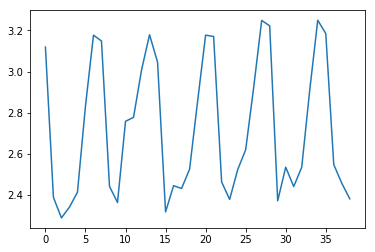

In [26]:
plt.plot(testpreds[129])

In [27]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [28]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              2.284458   
air_0164b9927d20bcc3_2017-04-23              1.520342   
air_0241aa3964b7f861_2017-04-23              2.414138   
air_0328696196e46f18_2017-04-23              2.178070   
air_034a3d5b40d5b1b1_2017-04-23              3.442876   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   8.820357  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.573790  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23  10.180129  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.829253  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  30.276794

In [29]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [30]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [31]:
submission.to_csv("../submission/3001eb_lgb_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')